In [10]:
# Check if affines now match after using *_ses01.nii.gz files
subject_id = 'sub-004'
roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / 'l_face_word_dual_cluster.nii.gz'
roi_img = nib.load(roi_file)

print("Checking affine alignment:")
for session in ['01', '02', '03']:
    if session == '01':
        cope_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / 'cope13.feat' / 'stats' / 'zstat1.nii.gz'
    else:
        cope_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat' / 'cope13.feat' / 'stats' / 'zstat1_ses01.nii.gz'
    
    cope_img = nib.load(cope_file)
    
    print(f"Session {session} (using {cope_file.name}):")
    print(f"  Shapes match: {roi_img.shape == cope_img.shape}")
    print(f"  Affines match: {np.allclose(roi_img.affine, cope_img.affine)}")

Checking affine alignment:
Session 01 (using zstat1.nii.gz):
  Shapes match: True
  Affines match: True
Session 02 (using zstat1_ses01.nii.gz):
  Shapes match: True
  Affines match: True
Session 03 (using zstat1_ses01.nii.gz):
  Shapes match: True
  Affines match: True


In [1]:
# Condition-based Functional ROI Creation
"""
Condition-based Functional ROI Creation
Uses individual condition activations (face>all, word>all) to define ROI
Then extracts contrast (face-word) from these voxels
"""

import numpy as np
import nibabel as nib
from pathlib import Path
from scipy import ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, surface

BASE_DIR = Path('/user_data/csimmon2/long_pt')

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-007': {'code': 'OT', 'sessions': ['01', '03', '04'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

def create_dual_cluster_roi(subject_id, roi_type='face_word', 
                           target_percentile=75, min_voxels_per_category=3000):
    """
    Create ROI from TWO separate clusters (face AND word, or object AND house)
    Combine via union to ensure both categories represented
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()} (Dual-Cluster)")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and individual condition copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 6, 'face'  # face>all
        cope2_num, cope2_name = 9, 'word'  # word>all
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 8, 'object'  # object>all
        cope2_num, cope2_name = 7, 'house'   # house>all
    
    # Load anatomical mask
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load individual conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # === CLUSTER 1 (e.g., face) ===
    print(f"\nFinding {cope1_name} cluster...")
    roi1_values = cope1_data[anat_mask]
    threshold1 = np.percentile(roi1_values, target_percentile)
    
    mask1 = (cope1_data > threshold1) & anat_mask
    labeled1, n_clusters1 = ndimage.label(mask1)
    
    if n_clusters1 > 0:
        cluster_sizes1 = [(labeled1 == i).sum() for i in range(1, n_clusters1 + 1)]
        largest_idx1 = np.argmax(cluster_sizes1) + 1
        cluster1_mask = (labeled1 == largest_idx1)
        n_vox1 = cluster_sizes1[largest_idx1 - 1]
        print(f"  {cope1_name}: {n_vox1} voxels (threshold z>{threshold1:.2f})")
    else:
        cluster1_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox1 = 0
        print(f"  {cope1_name}: No clusters found")
    
    # === CLUSTER 2 (e.g., word) ===
    print(f"Finding {cope2_name} cluster...")
    roi2_values = cope2_data[anat_mask]
    threshold2 = np.percentile(roi2_values, target_percentile)
    
    mask2 = (cope2_data > threshold2) & anat_mask
    labeled2, n_clusters2 = ndimage.label(mask2)
    
    if n_clusters2 > 0:
        cluster_sizes2 = [(labeled2 == i).sum() for i in range(1, n_clusters2 + 1)]
        largest_idx2 = np.argmax(cluster_sizes2) + 1
        cluster2_mask = (labeled2 == largest_idx2)
        n_vox2 = cluster_sizes2[largest_idx2 - 1]
        print(f"  {cope2_name}: {n_vox2} voxels (threshold z>{threshold2:.2f})")
    else:
        cluster2_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox2 = 0
        print(f"  {cope2_name}: No clusters found")
    
    # === UNION (no double counting) ===
    combined_mask = cluster1_mask | cluster2_mask
    n_total = np.sum(combined_mask)
    n_overlap = np.sum(cluster1_mask & cluster2_mask)
    
    print(f"\nCombined ROI:")
    print(f"  Total: {n_total} voxels")
    print(f"  {cope1_name} only: {n_vox1 - n_overlap}")
    print(f"  {cope2_name} only: {n_vox2 - n_overlap}")
    print(f"  Overlap: {n_overlap}")
    
    # Get center
    if n_total > 0:
        coords = np.where(combined_mask)
        center_vox = [np.mean(c) for c in coords]
        center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
        print(f"  Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    combined_img = nib.Nifti1Image(combined_mask.astype(np.float32), anat_roi.affine)
    nib.save(combined_img, output_file)
    print(f"  Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_total': n_total,
        'n_cluster1': n_vox1,
        'n_cluster2': n_vox2,
        'n_overlap': n_overlap,
        'cluster1_mask': cluster1_mask,
        'cluster2_mask': cluster2_mask
    }

# Create dual-cluster ROIs
roi_results_dual = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_dual[subject_id] = {}
    roi_results_dual[subject_id]['face_word'] = create_dual_cluster_roi(subject_id, 'face_word')
    roi_results_dual[subject_id]['object_house'] = create_dual_cluster_roi(subject_id, 'object_house')

# Summary
print("\n" + "="*60)
print("DUAL-CLUSTER ROI SUMMARY")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    fw = roi_results_dual[subject_id]['face_word']
    oh = roi_results_dual[subject_id]['object_house']
    print(f"  Face-Word: {fw['n_total']} voxels (face={fw['n_cluster1']}, word={fw['n_cluster2']}, overlap={fw['n_overlap']})")
    print(f"  Object-House: {oh['n_total']} voxels (object={oh['n_cluster1']}, house={oh['n_cluster2']}, overlap={oh['n_overlap']})")


sub-004 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 5024 voxels (threshold z>0.35)
Finding word cluster...
  word: 3891 voxels (threshold z>0.00)

Combined ROI:
  Total: 8023 voxels
  face only: 4132
  word only: 2999
  Overlap: 892
  Center: (-31.3, -44.1, -2.0)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_dual_cluster.nii.gz

sub-004 - OBJECT_HOUSE (Dual-Cluster)

Finding object cluster...
  object: 6944 voxels (threshold z>1.86)
Finding house cluster...
  house: 7634 voxels (threshold z>0.39)

Combined ROI:
  Total: 13734 voxels
  object only: 6100
  house only: 6790
  Overlap: 844
  Center: (-24.7, -77.2, 13.3)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_dual_cluster.nii.gz

sub-021 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 4476 voxels (threshold z>5.53)
Finding word cluster...
  word: 2123 voxels (threshold z>-1.04)

Combined ROI:
  Total: 6366 voxels
  face only: 4243
  word only: 1890
  Overla

In [9]:
# Cell 1: Extraction function for anatomical parcel
def extract_contrast_values(subject_id, roi_type, use_anatomical_only=False):
    """Extract face-word or object-house contrast from ROI"""
    hemi = SUBJECTS[subject_id]['hemi']
    
    if use_anatomical_only:
        # Liu's approach - full anatomical mask
        if roi_type == 'face_word':
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        else:
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        roi_label = "Anatomical"
    else:
        # Your approach - functionally restricted
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
        roi_label = "Functional"
    
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    n_voxels = np.sum(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    for session in SUBJECTS[subject_id]['sessions']:
        # Use ses01-registered version for all sessions except ses-01
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[session] = zstat[voxel_indices]
        else:
            print(f"  ⚠️  Warning: {zstat_filename} not found for {subject_id} ses-{session}")
    
    return session_data, n_voxels, roi_label

def compare_sessions_both_approaches(subject_id, roi_type='face_word'):
    """Compare both ROI approaches"""
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    
    print(f"\n{'='*80}")
    print(f"{code} - {roi_name}")
    print(f"{'='*80}")
    
    for use_anat in [False, True]:
        session_data, n_voxels, roi_label = extract_contrast_values(
            subject_id, roi_type, use_anatomical_only=use_anat
        )
        
        sessions = sorted(session_data.keys())
        
        print(f"\n{roi_label} ROI ({n_voxels} voxels)")
        print("-"*80)
        
        # Pairwise comparisons
        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                ses1, ses2 = sessions[i], sessions[j]
                
                n1 = len(session_data[ses1])
                n2 = len(session_data[ses2])
                df = n1 + n2 - 2
                
                t_stat, p_val = stats.ttest_ind(session_data[ses1], session_data[ses2])
                
                mean1 = session_data[ses1].mean()
                mean2 = session_data[ses2].mean()
                std1 = session_data[ses1].std()
                std2 = session_data[ses2].std()
                diff = mean2 - mean1
                
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                comparison = f"ses-{ses1} vs ses-{ses2}"
                if ses1 == sessions[0] and ses2 == sessions[1]:
                    comparison += " [Liu: expect ns for UD]"
                
                print(f"\n  {comparison}:")
                print(f"    n1={n1}, n2={n2}, df={df}")
                print(f"    Mean: {mean1:.2f} (SD={std1:.2f}) → {mean2:.2f} (SD={std2:.2f}), Δ={diff:+.2f}")
                print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")

In [5]:
# Cell 2: Run comparisons
from scipy import stats

print("COMPARISON: Functional vs Anatomical ROI Approaches")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        compare_sessions_both_approaches(subject_id, roi_type)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

COMPARISON: Functional vs Anatomical ROI Approaches

UD - Face-Word

Functional ROI (8023 voxels)
--------------------------------------------------------------------------------

  ses-01 vs ses-02 [Liu: expect ns for UD]:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.44 (SD=1.53), Δ=-1.18
    t=49.526, p=0.0000 ***

  ses-01 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.63 (SD=1.19), Δ=-0.99
    t=46.394, p=0.0000 ***

  ses-01 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.40 (SD=1.58), Δ=-0.23
    t=9.364, p=0.0000 ***

  ses-01 vs ses-06:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.87 (SD=1.24), Δ=+0.25
    t=-11.379, p=0.0000 ***

  ses-02 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 0.63 (SD=1.19), Δ=+0.19
    t=-8.953, p=0.0000 ***

  ses-02 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 1.40 (SD=1.58), Δ=+0.96
    t=-38.967, p=0.0000 ***

  ses-02 vs ses

In [8]:
# Extract cope 13 and 14 from dual-cluster ROIs

def extract_dual_cluster_longitudinal(subject_id, roi_type='face_word'):
    """Extract contrast from dual-cluster ROI across sessions"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    session_means = {}
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Use ses01-registered version for all sessions except ses-01
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            t_stats = zstat_data[voxel_indices]
            
            # Store for Figure 5
            session_data[session] = np.column_stack([world_coords, t_stats])
            session_means[session] = t_stats.mean()
            
            print(f"{subject_id} {roi_type} ses-{session}: mean={t_stats.mean():.2f}, std={t_stats.std():.2f}")
        else:
            print(f"  ⚠️  Warning: {zstat_filename} not found for {subject_id} ses-{session}")
    
    return session_data, session_means

# Extract for all subjects
print("Extracting dual-cluster ROI data...")
print("="*60)

dual_extractions = {}
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    dual_extractions[subject_id] = {}
    
    for roi_type in ['face_word', 'object_house']:
        print(f"\n  {roi_type}:")
        data, means = extract_dual_cluster_longitudinal(subject_id, roi_type)
        dual_extractions[subject_id][roi_type] = {'data': data, 'means': means}

Extracting dual-cluster ROI data...

UD:

  face_word:
sub-004 face_word ses-01: mean=1.62, std=1.49
sub-004 face_word ses-02: mean=0.44, std=1.53
sub-004 face_word ses-03: mean=0.63, std=1.19
sub-004 face_word ses-05: mean=1.40, std=1.58
sub-004 face_word ses-06: mean=1.87, std=1.24

  object_house:
sub-004 object_house ses-01: mean=0.73, std=1.10
sub-004 object_house ses-02: mean=2.38, std=1.75
sub-004 object_house ses-03: mean=2.73, std=1.71
sub-004 object_house ses-05: mean=4.98, std=1.58
sub-004 object_house ses-06: mean=1.82, std=1.88

TC:

  face_word:
sub-021 face_word ses-01: mean=2.95, std=2.03
sub-021 face_word ses-02: mean=0.95, std=1.47
sub-021 face_word ses-03: mean=0.08, std=1.95

  object_house:
sub-021 object_house ses-01: mean=0.39, std=1.58
sub-021 object_house ses-02: mean=-0.19, std=1.40
sub-021 object_house ses-03: mean=-0.91, std=1.51


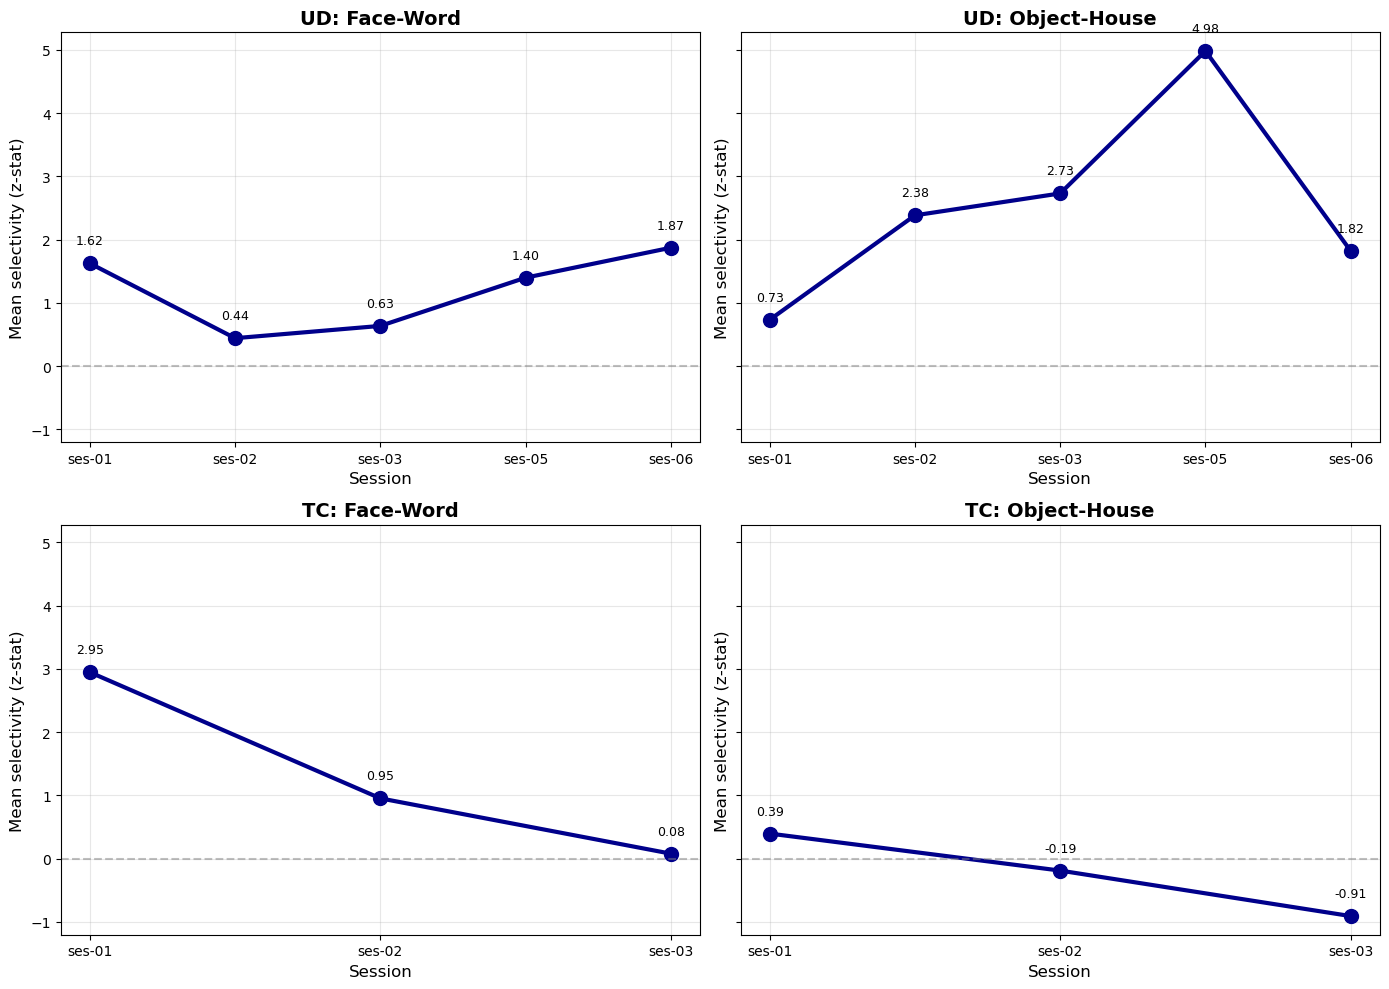


Extraction and visualization complete!


In [14]:
# Plot longitudinal progression

#fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for subj_idx, subject_id in enumerate(['sub-004', 'sub-021']):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for roi_idx, roi_type in enumerate(['face_word', 'object_house']):
        ax = axes[subj_idx, roi_idx]
        
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        # Get values in order
        sessions_available = [s for s in sessions if s in means_dict]
        means = [means_dict[s] for s in sessions_available]
        
        # Plot
        ax.plot(range(len(means)), means, 'o-', linewidth=3, markersize=10, color='darkblue')
        ax.set_xticks(range(len(sessions_available)))
        ax.set_xticklabels([f'ses-{s}' for s in sessions_available])
        ax.set_ylabel('Mean selectivity (z-stat)', fontsize=12)
        ax.set_xlabel('Session', fontsize=12)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # Title
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        ax.set_title(f'{code}: {roi_label}', fontsize=14, fontweight='bold')
        
        # Annotate values
        for i, (ses, val) in enumerate(zip(sessions_available, means)):
            ax.text(i, val + 0.3, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'dual_cluster_longitudinal.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("Extraction and visualization complete!")

In [6]:
# 1. Statistical comparison between sessions (matching Liu's analysis)

from scipy import stats

print("="*80)
print("STATISTICAL ANALYSIS: Pairwise Session Comparisons")
print("="*80)

def compare_sessions_stats(subject_id, roi_type='face_word'):
    """T-tests between all session pairs"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    # Load all sessions
    session_data = {}
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[session] = zstat[voxel_indices]
    
    sessions = sorted(session_data.keys())
    
    print(f"\n{SUBJECTS[subject_id]['code']} - {roi_type.upper()}")
    print("-"*60)
    
    # Pairwise comparisons
    results = []
    for i in range(len(sessions)):
        for j in range(i+1, len(sessions)):
            ses1, ses2 = sessions[i], sessions[j]
            
            t_stat, p_val = stats.ttest_ind(session_data[ses1], session_data[ses2])
            
            df = len(session_data[ses1]) + len(session_data[ses2]) - 2
            print(f"n1={len(session_data[ses1])}, n2={len(session_data[ses2])}, df={df}")
            
            mean1 = session_data[ses1].mean()
            mean2 = session_data[ses2].mean()
            diff = mean2 - mean1
            
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            
            # Highlight ses-1 vs ses-2
            comparison = f"ses-{ses1} vs ses-{ses2}"
            if ses1 == sessions[0] and ses2 == sessions[1]:
                comparison += " [Liu: expect ns]"
            
            print(f"  {comparison}:")
            print(f"    Mean: {mean1:.2f} → {mean2:.2f} (Δ={diff:+.2f})")
            print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")
            
            results.append({
                'ses1': ses1, 'ses2': ses2,
                'mean1': mean1, 'mean2': mean2,
                't': t_stat, 'p': p_val, 'sig': sig
            })
    
    return results

# Run for both subjects
stats_results = {}
for subject_id in ['sub-004', 'sub-021']:
    stats_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        stats_results[subject_id][roi_type] = compare_sessions_stats(subject_id, roi_type)

STATISTICAL ANALYSIS: Pairwise Session Comparisons

UD - FACE_WORD
------------------------------------------------------------
n1=8023, n2=8023, df=16044
  ses-01 vs ses-02 [Liu: expect ns]:
    Mean: 1.62 → 0.47 (Δ=-1.15)
    t=55.529, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-01 vs ses-03:
    Mean: 1.62 → 0.29 (Δ=-1.34)
    t=65.600, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-01 vs ses-05:
    Mean: 1.62 → 1.27 (Δ=-0.35)
    t=16.726, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-01 vs ses-06:
    Mean: 1.62 → 1.45 (Δ=-0.17)
    t=8.252, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-02 vs ses-03:
    Mean: 0.47 → 0.29 (Δ=-0.19)
    t=11.006, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-02 vs ses-05:
    Mean: 0.47 → 1.27 (Δ=+0.80)
    t=-44.682, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-02 vs ses-06:
    Mean: 0.47 → 1.45 (Δ=+0.98)
    t=-56.608, p=0.0000 ***
n1=8023, n2=8023, df=16044
  ses-03 vs ses-05:
    Mean: 0.29 → 1.27 (Δ=+0.99)
    t=-56.372, p=0.0000 ***
n1=80


Creating Figure 5 visualizations...
Saved: /user_data/csimmon2/long_pt/analyses/sub-004_face_word_figure5_liu_style.png


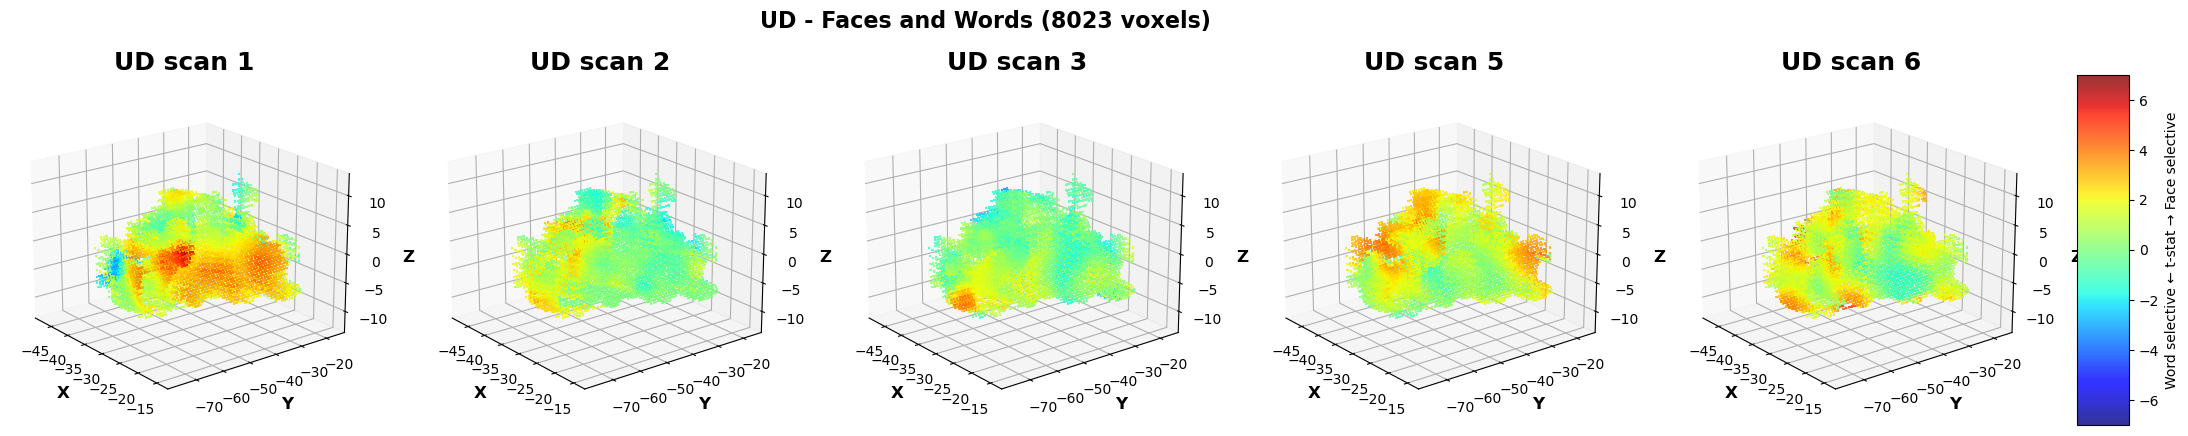

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_object_house_figure5_liu_style.png


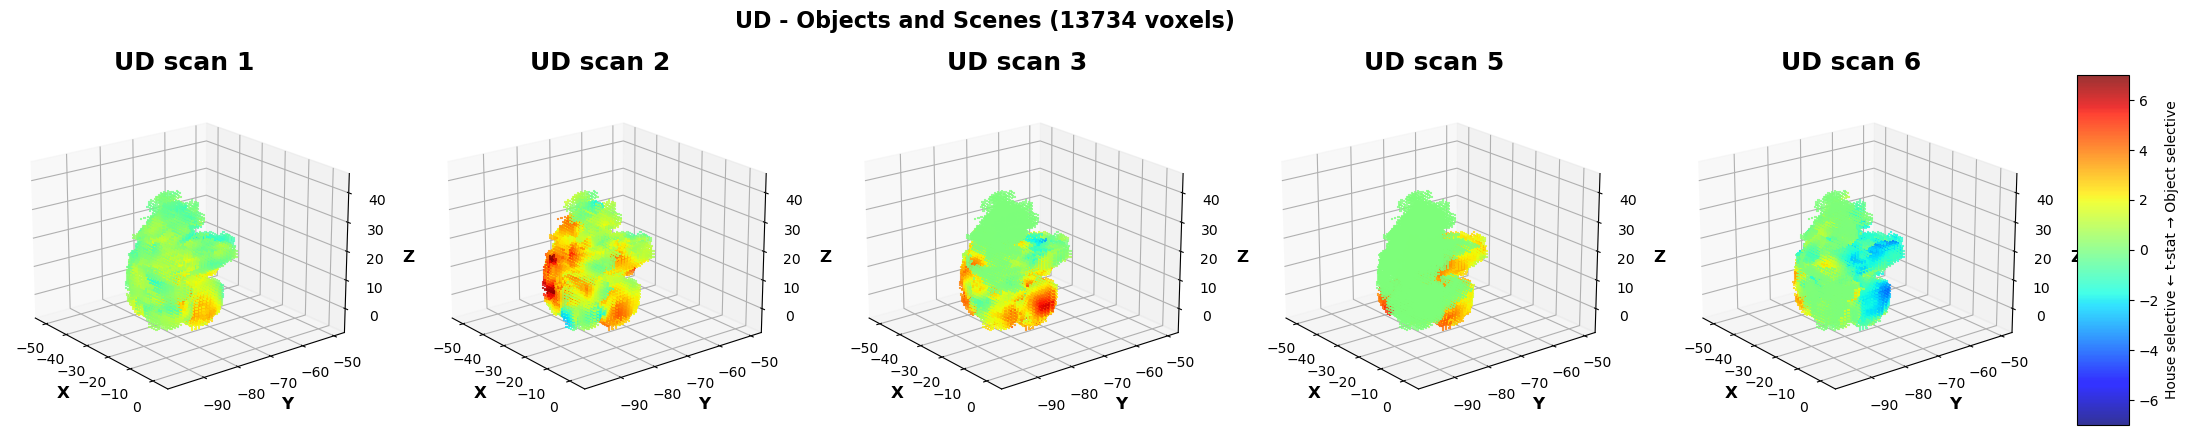

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_face_word_figure5_liu_style.png


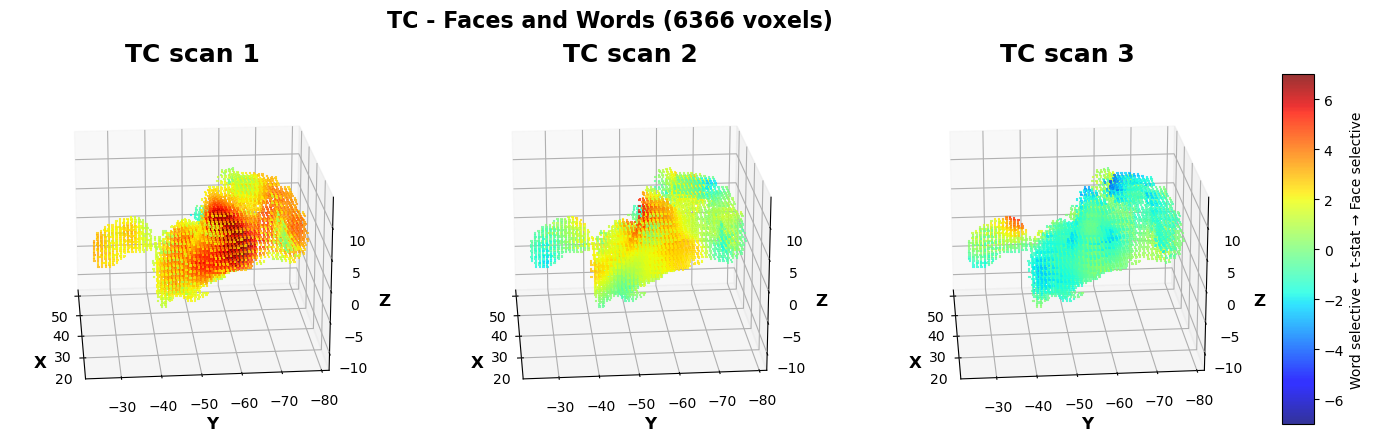

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_object_house_figure5_liu_style.png


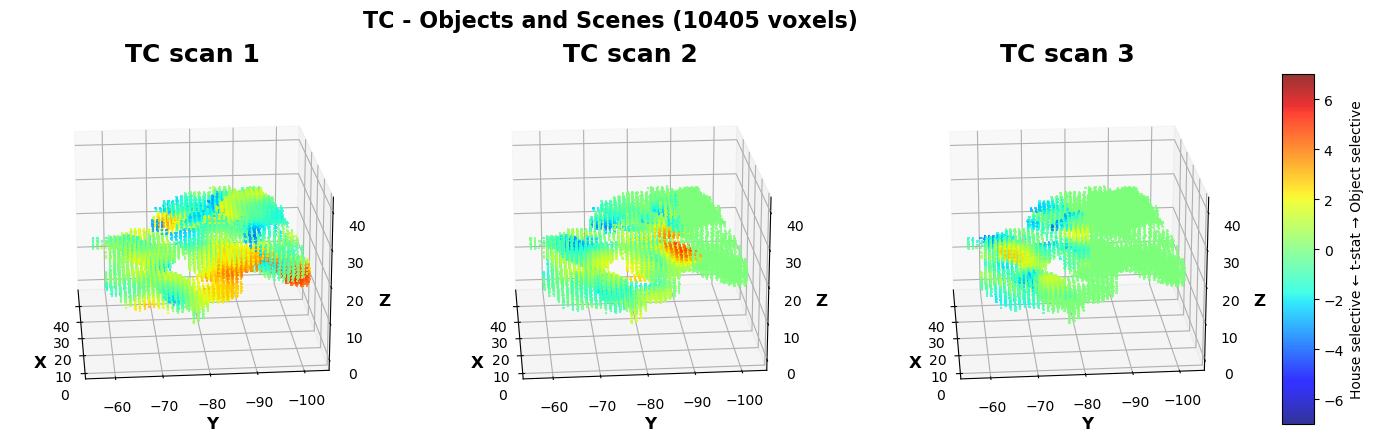

In [9]:
# 2. Figure 5 style visualization with dual-cluster ROIs

def create_figure5_liu_style(subject_id, roi_type='face_word', save_path=None):
    """
    Recreate Liu's Figure 5 visualization
    3D scatter plots showing selectivity changes over time
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    info = SUBJECTS[subject_id]
    
    # Load dual-cluster ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Extract contrast for all sessions
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    for session in info['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            t_stats = zstat_data[voxel_indices]
            session_data[session] = t_stats
    
    sessions = sorted(session_data.keys())
    n_sessions = len(sessions)
    
    # Create figure
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for i, ses in enumerate(sessions):
        t_stats = session_data[ses]
        
        ax = fig.add_subplot(1, n_sessions, i+1, projection='3d')
        
        # View angle (match Liu)
        view = (20, 175) if info['hemi'] == 'r' else (20, 322)
        
        scatter = ax.scatter(world_coords[:,0], world_coords[:,1], world_coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{info["code"]} scan {int(ses)}', fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    # Colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t-stat → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t-stat → Object selective', fontsize=10)
    
    roi_label = 'Faces and Words' if roi_type == 'face_word' else 'Objects and Scenes'
    n_voxels = len(world_coords)
    fig.suptitle(f'{info["code"]} - {roi_label} ({n_voxels} voxels)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Create Liu-style Figure 5
print("\nCreating Figure 5 visualizations...")
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_figure5_liu_style.png'
        create_figure5_liu_style(subject_id, roi_type, save_path)

In [10]:
# 3. Summary table comparing to Liu's findings

print("\n" + "="*80)
print("SUMMARY: COMPARISON TO LIU ET AL. FINDINGS")
print("="*80)

print("\nLIU'S FINDING:")
print("  'Significant differences in t(face-word) between any two sessions'")
print("  'EXCEPT for comparisons between scans 1 and 2'")
print()

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} - Face-Word:")
    print("-"*40)
    
    # Get ses-1 vs ses-2 result
    fw_results = stats_results[subject_id]['face_word']
    sessions = sorted(SUBJECTS[subject_id]['sessions'])
    
    ses1_vs_2 = [r for r in fw_results if r['ses1'] == sessions[0] and r['ses2'] == sessions[1]]
    
    if ses1_vs_2:
        r = ses1_vs_2[0]
        print(f"  Scan 1 vs Scan 2: p={r['p']:.4f} {r['sig']}")
        if r['sig'] == 'ns':
            print(f"    ✓ MATCHES Liu (non-significant)")
        else:
            print(f"    ✗ Differs from Liu (significant)")
    
    # Check other comparisons
    other_comparisons = [r for r in fw_results if not (r['ses1'] == sessions[0] and r['ses2'] == sessions[1])]
    n_sig = sum(1 for r in other_comparisons if r['sig'] != 'ns')
    
    print(f"  Other comparisons: {n_sig}/{len(other_comparisons)} significant")
    if n_sig == len(other_comparisons):
        print(f"    ✓ MATCHES Liu (all other comparisons significant)")
    else:
        print(f"    ~ Partial match ({n_sig}/{len(other_comparisons)} significant)")
    
    # Show trajectory
    means_dict = dual_extractions[subject_id]['face_word']['means']
    trajectory = [means_dict[s] for s in sessions if s in means_dict]
    print(f"  Trajectory: {' → '.join([f'{v:.2f}' for v in trajectory])}")

print("\n" + "="*80)


SUMMARY: COMPARISON TO LIU ET AL. FINDINGS

LIU'S FINDING:
  'Significant differences in t(face-word) between any two sessions'
  'EXCEPT for comparisons between scans 1 and 2'


UD - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 9/9 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 1.62 → 0.47 → 0.29 → 1.27 → 1.45

TC - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 2/2 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 2.95 → 1.29 → -0.61



In [12]:
# Comprehensive results summary

print("="*80)
print("DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY")
print("="*80)

print("\n" + "="*80)
print("1. ROI COMPOSITION (ses-01)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} ({subject_id}):")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        result = roi_results_dual[subject_id][roi_type]
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        
        print(f"\n  {roi_label} ROI:")
        print(f"    Total voxels: {result['n_total']}")
        
        if roi_type == 'face_word':
            print(f"    Face-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    Word-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        else:
            print(f"    Object-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    House-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        print(f"    Overlap: {result['n_overlap']} ({100*result['n_overlap']/result['n_total']:.1f}%)")

print("\n" + "="*80)
print("2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        print(f"\n  {roi_label}:")
        for ses in SUBJECTS[subject_id]['sessions']:
            if ses in means_dict:
                print(f"    ses-{ses}: {means_dict[ses]:+.2f}")

print("\n" + "="*80)
print("3. SESSION-TO-SESSION CHANGES")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
        
        print(f"\n  {roi_label}:")
        for i in range(len(sessions)-1):
            ses1, ses2 = sessions[i], sessions[i+1]
            change = means_dict[ses2] - means_dict[ses1]
            print(f"    ses-{ses1} → ses-{ses2}: {change:+.2f}")
        
        # Overall change
        if len(sessions) >= 2:
            total_change = means_dict[sessions[-1]] - means_dict[sessions[0]]
            print(f"    Overall (ses-{sessions[0]} → ses-{sessions[-1]}): {total_change:+.2f}")

print("\n" + "="*80)
print("4. COMPARISON TO LIU ET AL. EXPECTATIONS")
print("="*80)

print("\nLiu et al. findings:")
print("  UD: Progressive INCREASE in face-word selectivity")
print("  TC: Significant changes over time")
print("  OT: No significant change (control)")

print("\nYour findings:")
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    means_dict = dual_extractions[subject_id]['face_word']['means']
    sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
    
    if len(sessions) >= 2:
        baseline = means_dict[sessions[0]]
        final = means_dict[sessions[-1]]
        change = final - baseline
        
        pattern = "INCREASE" if change > 0 else "DECREASE"
        print(f"  {code}: {pattern} ({baseline:.2f} → {final:.2f}, Δ={change:+.2f})")

print("\n" + "="*80)
print("5. KEY OBSERVATIONS")
print("="*80)

# Analyze patterns
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    fw_means = dual_extractions[subject_id]['face_word']['means']
    oh_means = dual_extractions[subject_id]['object_house']['means']
    
    fw_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in fw_means]
    oh_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in oh_means]
    
    print(f"\n{code}:")
    
    # Face-word trajectory
    if len(fw_sessions) >= 2:
        fw_values = [fw_means[s] for s in fw_sessions]
        fw_trend = "increasing" if fw_values[-1] > fw_values[0] else "decreasing"
        fw_stable = all(abs(fw_values[i+1] - fw_values[i]) < 0.5 for i in range(len(fw_values)-1))
        
        print(f"  Face-Word: {fw_trend} trajectory")
        if fw_stable:
            print(f"    Relatively stable (max change < 0.5)")
    
    # Object-house trajectory  
    if len(oh_sessions) >= 2:
        oh_values = [oh_means[s] for s in oh_sessions]
        oh_trend = "increasing" if oh_values[-1] > oh_values[0] else "decreasing"
        oh_stable = all(abs(oh_values[i+1] - oh_values[i]) < 0.5 for i in range(len(oh_values)-1))
        
        print(f"  Object-House: {oh_trend} trajectory")
        if oh_stable:
            print(f"    Relatively stable (max change < 0.5)")

print("\n" + "="*80)
print("END OF SUMMARY")
print("="*80)

DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY

1. ROI COMPOSITION (ses-01)

UD (sub-004):
----------------------------------------

  Face-Word ROI:
    Total voxels: 8023
    Face-only: 4132 (51.5%)
    Word-only: 2999 (37.4%)
    Overlap: 892 (11.1%)

  Object-House ROI:
    Total voxels: 13734
    Object-only: 6100 (44.4%)
    House-only: 6790 (49.4%)
    Overlap: 844 (6.1%)

TC (sub-021):
----------------------------------------

  Face-Word ROI:
    Total voxels: 6366
    Face-only: 4243 (66.7%)
    Word-only: 1890 (29.7%)
    Overlap: 233 (3.7%)

  Object-House ROI:
    Total voxels: 10405
    Object-only: 6223 (59.8%)
    House-only: 4088 (39.3%)
    Overlap: 94 (0.9%)

2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)

UD:
----------------------------------------

  Face-Word:
    ses-01: +1.62
    ses-02: +0.47
    ses-03: +0.29
    ses-05: +1.27
    ses-06: +1.45

  Object-House:
    ses-01: +0.73
    ses-02: +1.89
    ses-03: +1.37
    ses-05: +1.20
    ses-06: -0.49

In [ ]:
# Stats Complete table generation cell with range filled - ANATOMICAL PARCEL ROI
import pandas as pd
from scipy.stats import chi2

# Liu's reported values (with range for UD middle sessions)
liu_fw = {
    'sub-004': [
        ('ses-01→02', '-', '0.844 ns (t-test)'),
        ('ses-02→03', '8.10-21.06', '<0.004 **'),
        ('ses-03→05', '8.10-21.06', '<0.004 **'),
        ('ses-05→06', '3.273', '0.070 ns')
    ],
    'sub-021': [
        ('ses-01→02', '87.699', '<0.001 ***'),
        ('ses-02→03', '9.333', '0.002 **')
    ]
}

# Run McNemar and collect results
def run_mcnemar_collect(subject_id, roi_type):
    """Run McNemar and return results list"""
    hemi = SUBJECTS[subject_id]['hemi']
    
    if roi_type == 'face_word':
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
    else:
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
    
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    contrast_cope = 13 if roi_type == 'face_word' else 14
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Extract values
    session_values = {}
    for session in sessions:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            session_values[session] = zstat_data[voxel_indices]
    
    results = []
    for i in range(len(sessions) - 1):
        ses1, ses2 = sessions[i], sessions[i+1]
        if ses1 not in session_values or ses2 not in session_values:
            continue
        
        vals1, vals2 = session_values[ses1], session_values[ses2]
        mean1, mean2 = vals1.mean(), vals2.mean()
        
        face1 = vals1 > (mean1 + 1.5)
        word1 = vals1 < (mean1 - 1.5)
        face2 = vals2 > (mean2 + 1.5)
        word2 = vals2 < (mean2 - 1.5)
        
        b = np.sum(face1 & word2)
        c = np.sum(word1 & face2)
        chi2_stat = (abs(b - c) - 1)**2 / (b + c) if (b + c) > 0 else 0
        p_val = 1 - chi2.cdf(chi2_stat, df=1)
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        results.append((f'ses-{ses1}→{ses2}', f'{chi2_stat:.3f}', f'{p_val:.4f} {sig}'))
    
    return results

# Collect your results
your_fw = {sid: run_mcnemar_collect(sid, 'face_word') for sid in ['sub-004', 'sub-021']}
your_oh = {sid: run_mcnemar_collect(sid, 'object_house') for sid in ['sub-004', 'sub-021']}

# TABLE 1: Face-Word Replication
print("\n" + "="*100)
print("TABLE 1: Face-Word Competition (Replication of Liu et al.)")
print("="*100)

fw_data = []
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    liu_data = {r[0]: (r[1], r[2]) for r in liu_fw[subject_id]}
    your_data = {r[0]: (r[1], r[2]) for r in your_fw[subject_id]}
    
    all_comps = sorted(set(liu_data.keys()) | set(your_data.keys()))
    for comp in all_comps:
        liu_chi2, liu_p = liu_data.get(comp, ('-', '-'))
        your_chi2, your_p = your_data.get(comp, ('-', '-'))
        fw_data.append([code, comp, liu_chi2, liu_p, your_chi2, your_p])

df1 = pd.DataFrame(fw_data, columns=['Subject', 'Comparison', 'Liu χ²', 'Liu p-value', 'Your χ²', 'Your p-value'])
print(df1.to_string(index=False))

# TABLE 2: Object-House Novel Analysis
print("\n\n" + "="*100)
print("TABLE 2: Object-House Competition (Novel Analysis)")
print("="*100)

oh_data = []
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    for comp, chi2_str, p_str in your_oh[subject_id]:
        oh_data.append([code, comp, chi2_str, p_str])

df2 = pd.DataFrame(oh_data, columns=['Subject', 'Comparison', 'χ²', 'p-value'])
print(df2.to_string(index=False))


TABLE 1: Face-Word Competition (Replication of Liu et al.)
Subject Comparison     Liu χ²       Liu p-value Your χ² Your p-value
     UD  ses-01→02          - 0.844 ns (t-test)  89.649   0.0000 ***
     UD  ses-02→03 8.10-21.06         <0.004 **   2.108    0.1466 ns
     UD  ses-03→05 8.10-21.06         <0.004 **   1.194    0.2745 ns
     UD  ses-05→06      3.273          0.070 ns 128.524   0.0000 ***
     TC  ses-01→02     87.699        <0.001 ***  51.200   0.0000 ***
     TC  ses-02→03      9.333          0.002 **   0.504    0.4778 ns


TABLE 2: Object-House Competition (Novel Analysis)
Subject Comparison       χ²    p-value
     UD  ses-01→02    5.639   0.0176 *
     UD  ses-02→03    0.009  0.9236 ns
     UD  ses-03→05  418.010 0.0000 ***
     UD  ses-05→06 1221.336 0.0000 ***
     TC  ses-01→02   11.813 0.0006 ***
     TC  ses-02→03    0.434  0.5102 ns


In [36]:
# McNemar with FUNCTIONAL dual-cluster ROIs
import pandas as pd
from scipy.stats import chi2

def run_mcnemar_functional(subject_id, roi_type):
    """Run McNemar on functional dual-cluster ROI"""
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load FUNCTIONAL ROI (dual-cluster)
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Extract values
    session_values = {}
    for session in sessions:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            session_values[session] = zstat_data[voxel_indices]
    
    results = []
    for i in range(len(sessions) - 1):
        ses1, ses2 = sessions[i], sessions[i+1]
        if ses1 not in session_values or ses2 not in session_values:
            continue
        
        vals1, vals2 = session_values[ses1], session_values[ses2]
        mean1, mean2 = vals1.mean(), vals2.mean()
        
        cat1_high = vals1 > (mean1 + 1.5)
        cat1_low = vals1 < (mean1 - 1.5)
        cat2_high = vals2 > (mean2 + 1.5)
        cat2_low = vals2 < (mean2 - 1.5)
        
        b = np.sum(cat1_high & cat2_low)
        c = np.sum(cat1_low & cat2_high)
        chi2_stat = (abs(b - c) - 1)**2 / (b + c) if (b + c) > 0 else 0
        p_val = 1 - chi2.cdf(chi2_stat, df=1)
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        results.append((f'ses-{ses1}→{ses2}', f'{chi2_stat:.3f}', f'{p_val:.4f} {sig}'))
    
    return results

# Liu's values (static)
liu_fw = {
    'sub-004': [
        ('ses-01→02', '-', '0.844 ns (t-test)'),
        ('ses-02→03', '8.10-21.06', '<0.004 **'),
        ('ses-03→05', '8.10-21.06', '<0.004 **'),
        ('ses-05→06', '3.273', '0.070 ns')
    ],
    'sub-021': [
        ('ses-01→02', '87.699', '<0.001 ***'),
        ('ses-02→03', '9.333', '0.002 **')
    ]
}

# Run on functional ROIs
your_fw = {sid: run_mcnemar_functional(sid, 'face_word') for sid in ['sub-004', 'sub-021']}
your_oh = {sid: run_mcnemar_functional(sid, 'object_house') for sid in ['sub-004', 'sub-021']}

# TABLE 1
print("\n" + "="*100)
print("TABLE 1: Face-Word Competition (Functional ROIs)")
print("="*100)

fw_data = []
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    liu_data = {r[0]: (r[1], r[2]) for r in liu_fw[subject_id]}
    your_data = {r[0]: (r[1], r[2]) for r in your_fw[subject_id]}
    
    all_comps = sorted(set(liu_data.keys()) | set(your_data.keys()))
    for comp in all_comps:
        liu_chi2, liu_p = liu_data.get(comp, ('-', '-'))
        your_chi2, your_p = your_data.get(comp, ('-', '-'))
        fw_data.append([code, comp, liu_chi2, liu_p, your_chi2, your_p])

df1 = pd.DataFrame(fw_data, columns=['Subject', 'Comparison', 'Liu χ²', 'Liu p', 'Your χ²', 'Your p'])
print(df1.to_string(index=False))

# TABLE 2
print("\n" + "="*100)
print("TABLE 2: Object-House Competition (Functional ROIs - Novel)")
print("="*100)

oh_data = []
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    for comp, chi2_str, p_str in your_oh[subject_id]:
        oh_data.append([code, comp, chi2_str, p_str])

df2 = pd.DataFrame(oh_data, columns=['Subject', 'Comparison', 'χ²', 'p-value'])
print(df2.to_string(index=False))


TABLE 1: Face-Word Competition (Functional ROIs)
Subject Comparison     Liu χ²             Liu p Your χ²     Your p
     UD  ses-01→02          - 0.844 ns (t-test) 129.643 0.0000 ***
     UD  ses-02→03 8.10-21.06         <0.004 **   0.308  0.5791 ns
     UD  ses-03→05 8.10-21.06         <0.004 **   1.210  0.2713 ns
     UD  ses-05→06      3.273          0.070 ns  88.994 0.0000 ***
     TC  ses-01→02     87.699        <0.001 ***  31.243 0.0000 ***
     TC  ses-02→03      9.333          0.002 **  37.959 0.0000 ***

TABLE 2: Object-House Competition (Functional ROIs - Novel)
Subject Comparison      χ²    p-value
     UD  ses-01→02  40.710 0.0000 ***
     UD  ses-02→03  33.513 0.0000 ***
     UD  ses-03→05 100.010 0.0000 ***
     UD  ses-05→06 459.002 0.0000 ***
     TC  ses-01→02  35.752 0.0000 ***
     TC  ses-02→03   0.100  0.7518 ns


/tmp/ipykernel_3375961/485166046.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


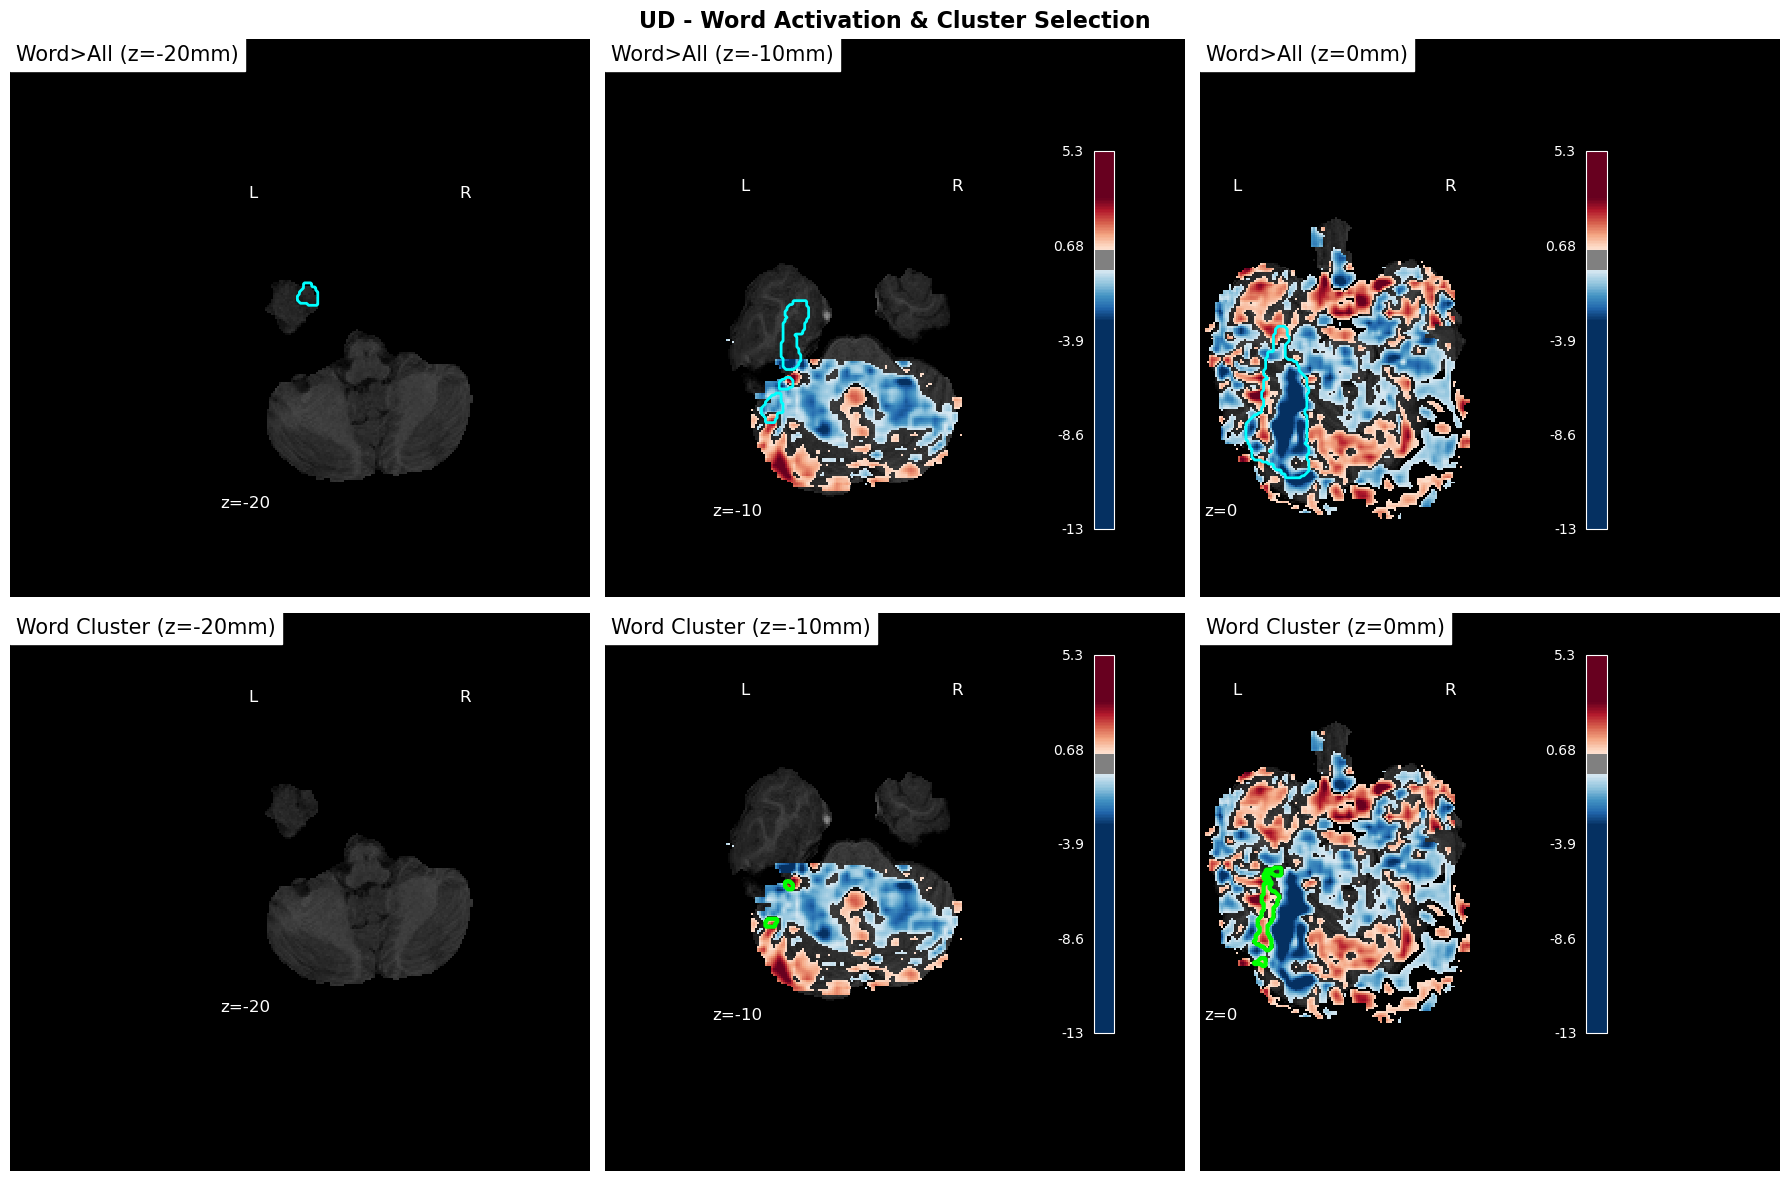

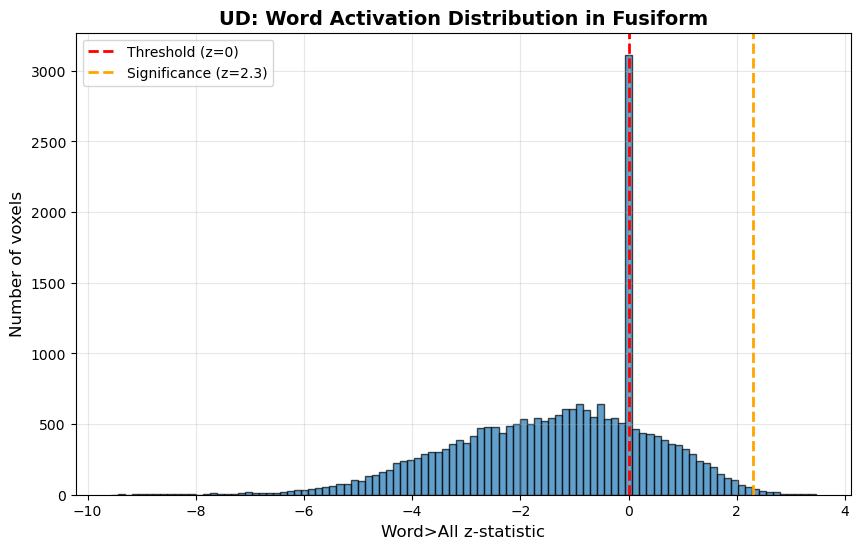

Word activation stats:
  Mean: -1.31
  Median: -1.03
  Min: -9.57, Max: 3.46
  Voxels > 0: 5033 (20.7%)
  Voxels > 2.3: 125 (0.5%)


In [4]:
# Visualize UD word activation

subject_id = 'sub-004'
hemi = 'l'

# Load files
anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
anat_boundary = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
word_activation = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                  'HighLevel.gfeat' / 'cope9.feat' / 'stats' / 'zstat1.nii.gz'
word_cluster = roi_results_dual[subject_id]['face_word']['cluster2_mask']

# Create word cluster image
word_cluster_img = nib.Nifti1Image(word_cluster.astype(np.float32), 
                                    nib.load(anat_boundary).affine)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Word activation with anatomical boundary
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[0, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word>All (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(anat_boundary, levels=[0.5], colors='cyan', linewidths=2)

# Row 2: Word cluster selection
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[1, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word Cluster (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(word_cluster_img, levels=[0.5], colors='lime', linewidths=3)

fig.suptitle('UD - Word Activation & Cluster Selection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'sub-004_word_cluster_review.png', dpi=150)
plt.show()

# Histogram
anat_mask = nib.load(anat_boundary).get_fdata() > 0
word_data = nib.load(word_activation).get_fdata()
word_values = word_data[anat_mask]

plt.figure(figsize=(10, 6))
plt.hist(word_values, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Threshold (z=0)')
plt.axvline(2.3, color='orange', linestyle='--', linewidth=2, label='Significance (z=2.3)')
plt.xlabel('Word>All z-statistic', fontsize=12)
plt.ylabel('Number of voxels', fontsize=12)
plt.title('UD: Word Activation Distribution in Fusiform', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Word activation stats:")
print(f"  Mean: {word_values.mean():.2f}")
print(f"  Median: {np.median(word_values):.2f}")
print(f"  Min: {word_values.min():.2f}, Max: {word_values.max():.2f}")
print(f"  Voxels > 0: {np.sum(word_values > 0)} ({100*np.sum(word_values > 0)/len(word_values):.1f}%)")
print(f"  Voxels > 2.3: {np.sum(word_values > 2.3)} ({100*np.sum(word_values > 2.3)/len(word_values):.1f}%)")

/tmp/ipykernel_3944036/3283939873.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


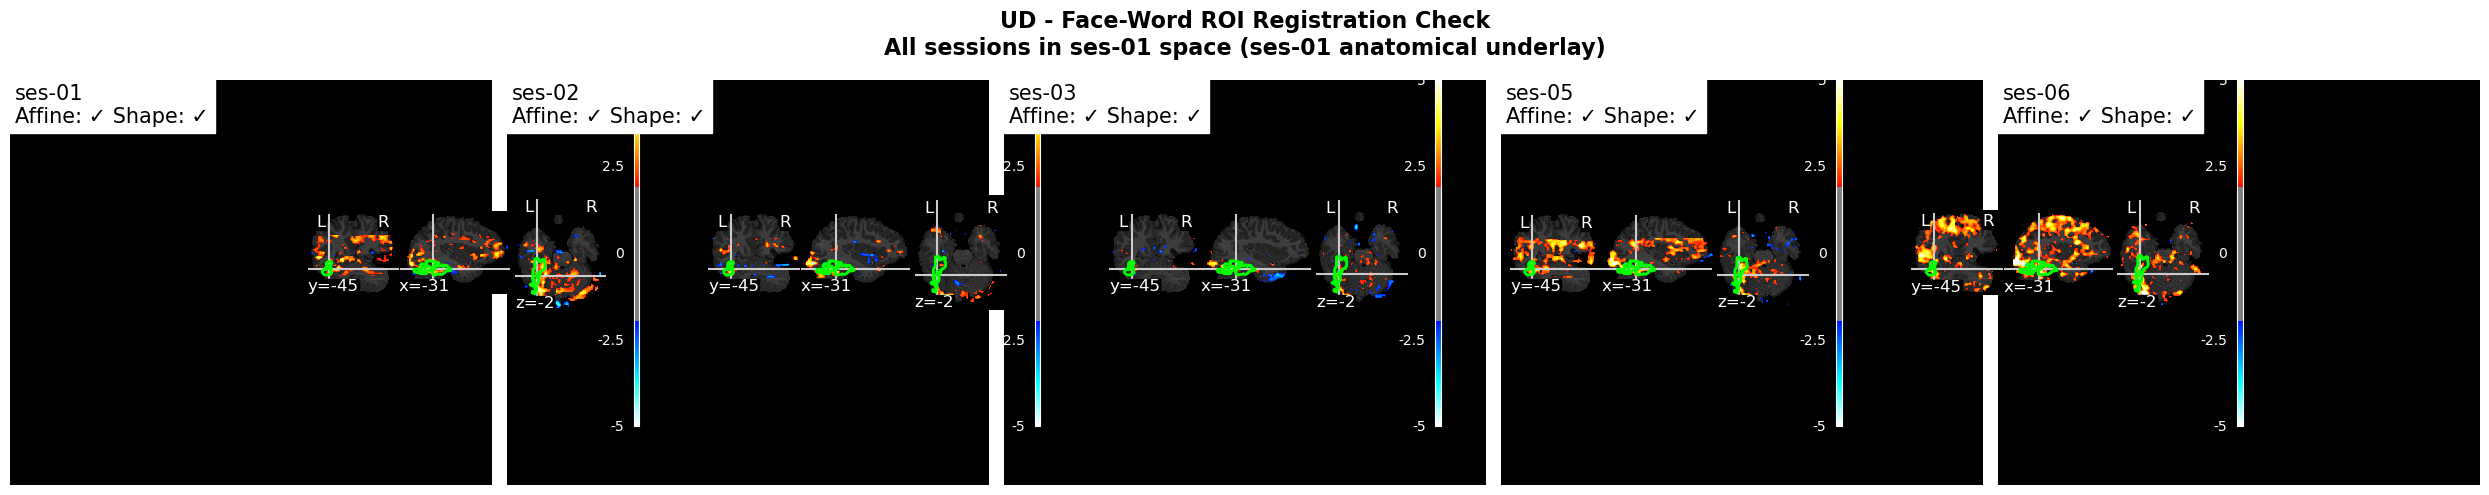


UD - Face-Word Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-05: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-06: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




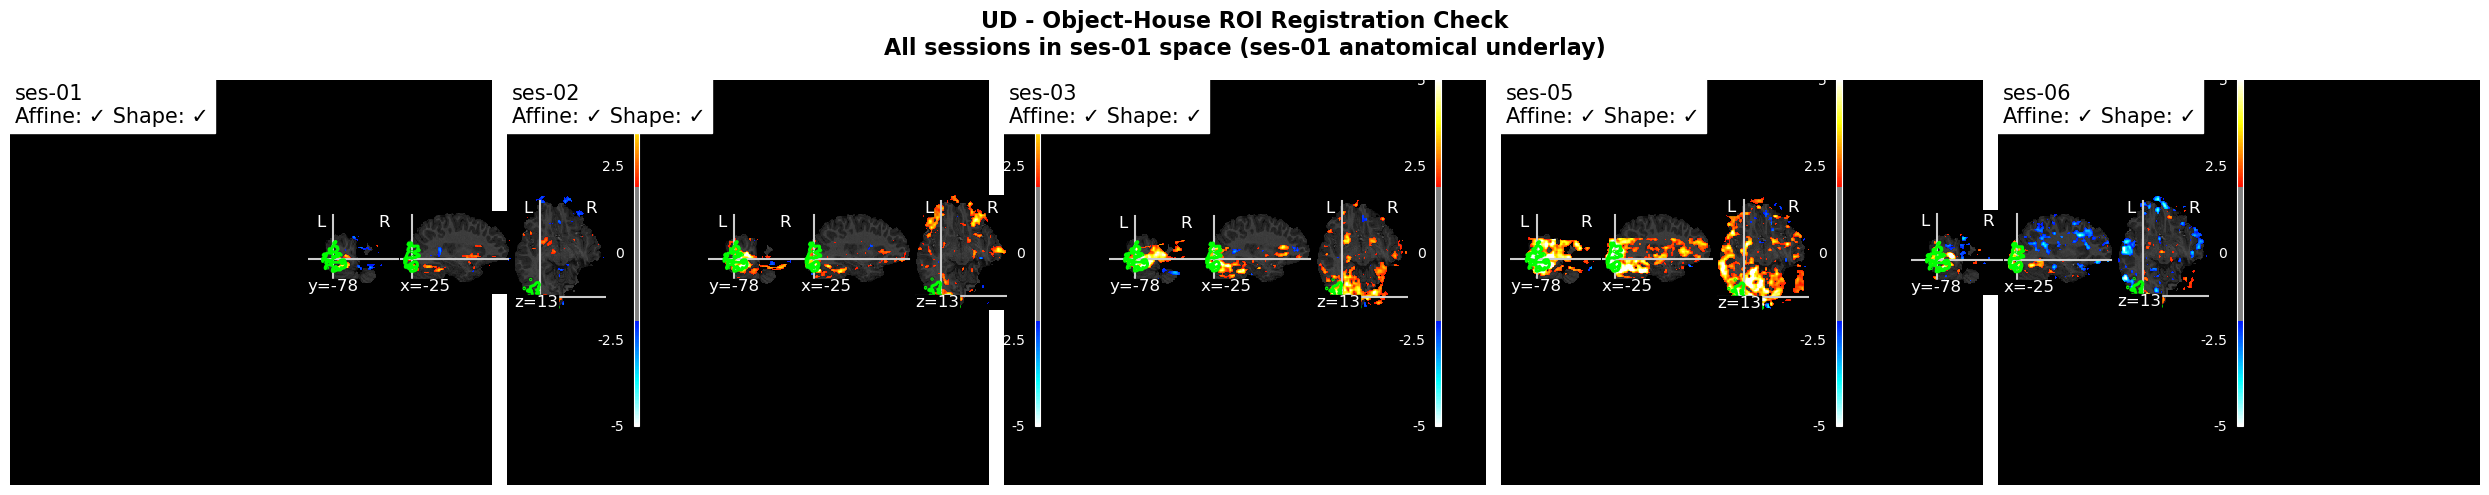


UD - Object-House Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-05: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-06: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




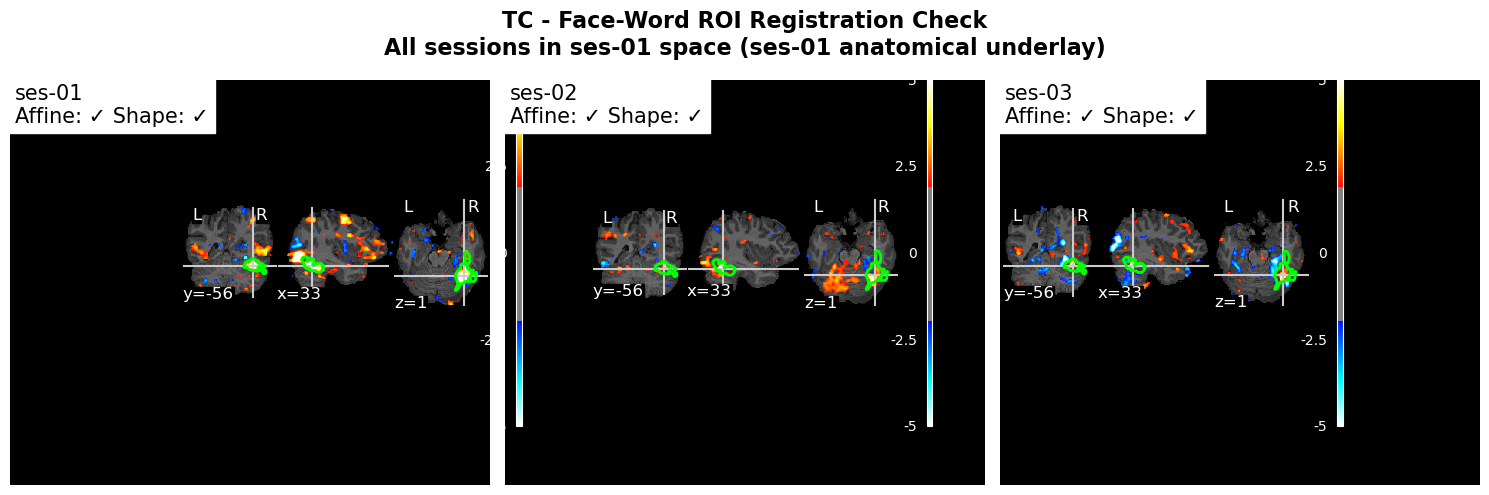


TC - Face-Word Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




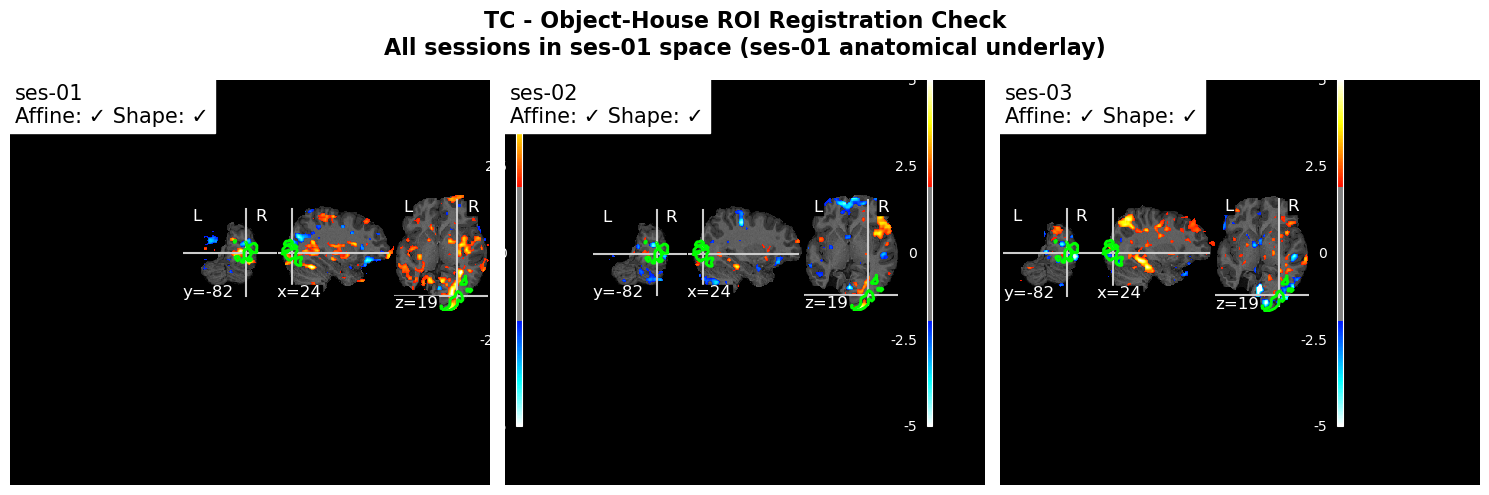


TC - Object-House Registration Summary:
  ses-01: zstat1.nii.gz (native)
    Affine match: ✓
    Shape match: ✓
  ses-02: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓
  ses-03: zstat1_ses01.nii.gz (registered)
    Affine match: ✓
    Shape match: ✓




In [12]:
# Visualization: Verify ses-01 registration with anatomical underlay
import matplotlib.pyplot as plt
from nilearn import plotting

def visualize_session_alignment(subject_id, roi_type='face_word', slice_coords=None):
    """
    Visualize that all sessions are properly registered to ses-01 space
    Shows ROI overlaid on each session's contrast map with anatomical underlay
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    code = SUBJECTS[subject_id]['code']
    
    # Load ses-01 anatomical as background
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    anat_img = nib.load(anat_file)
    
    # Load ROI (defined in ses-01 space)
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    
    # Get center of ROI for slicing if not provided
    if slice_coords is None:
        roi_coords = np.where(roi_img.get_fdata() > 0)
        center_vox = [int(np.mean(c)) for c in roi_coords]
        slice_coords = nib.affines.apply_affine(roi_img.affine, center_vox)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    
    # Create figure
    n_sessions = len(SUBJECTS[subject_id]['sessions'])
    fig, axes = plt.subplots(1, n_sessions, figsize=(5*n_sessions, 5))
    if n_sessions == 1:
        axes = [axes]
    
    fig.suptitle(f'{code} - {roi_name} ROI Registration Check\nAll sessions in ses-01 space (ses-01 anatomical underlay)', 
                 fontsize=16, fontweight='bold')
    
    for idx, session in enumerate(SUBJECTS[subject_id]['sessions']):
        # Load appropriate file
        if session == '01':
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        else:
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
        
        if zstat_file.exists():
            # Check affine match
            zstat_img = nib.load(zstat_file)
            affine_match = np.allclose(roi_img.affine, zstat_img.affine)
            shape_match = roi_img.shape == zstat_img.shape
            
            # Plot with anatomical background
            display = plotting.plot_stat_map(
                zstat_img,
                bg_img=anat_img,  # Use ses-01 anatomical as background
                cut_coords=slice_coords,
                display_mode='ortho',
                threshold=1.96,
                title=f'ses-{session}\nAffine: {"✓" if affine_match else "✗"} Shape: {"✓" if shape_match else "✗"}',
                axes=axes[idx],
                colorbar=True,
                vmax=5,
                cmap='cold_hot'
            )
            
            # Overlay ROI contours
            display.add_contours(roi_img, levels=[0.5], colors='lime', linewidths=2)
            
        else:
            axes[idx].text(0.5, 0.5, f'ses-{session}\nFile not found', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{code} - {roi_name} Registration Summary:")
    print("="*60)
    for session in SUBJECTS[subject_id]['sessions']:
        if session == '01':
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
            file_type = "zstat1.nii.gz (native)"
        else:
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            file_type = "zstat1_ses01.nii.gz (registered)"
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            affine_match = np.allclose(roi_img.affine, zstat_img.affine)
            shape_match = roi_img.shape == zstat_img.shape
            print(f"  ses-{session}: {file_type}")
            print(f"    Affine match: {'✓' if affine_match else '✗'}")
            print(f"    Shape match: {'✓' if shape_match else '✗'}")
        else:
            print(f"  ses-{session}: ✗ File not found")

# Visualize all subjects and ROI types
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        visualize_session_alignment(subject_id, roi_type)
        print("\n")

METHODS SECTION:
ROI Definition
Category-selective regions of interest (ROIs) were defined in native space for each participant using anatomical and functional constraints. For the fusiform gyrus/occipitotemporal sulcus (FG/OTS) face-word ROI, we first identified the anatomical boundaries of the fusiform gyrus using FreeSurfer's automatic parcellation (aparc) of the structural T1-weighted image. Specifically, we extracted the lateral fusiform label and applied 2 iterations of morphological dilation (fslmaths -dilM) to ensure adequate cortical depth coverage, resulting in anatomical search spaces of approximately 24,000 voxels.
Within these anatomical constraints, we employed a dual-cluster functional localization approach to ensure balanced representation of both face and word selective voxels. For each category (faces and words), we identified the largest cluster of voxels exceeding the 75th percentile of activation values for that category's individual contrast (face>all baseline [cope 6] and word>all baseline [cope 9]) within the anatomical mask. The final ROI was defined as the union of these two clusters, yielding ROIs of 6,000-8,000 voxels for face-word comparisons. An analogous procedure was applied for object-house ROIs using lateral occipital cortex and parahippocampal place area anatomical boundaries, with object>all baseline (cope 8) and house>all baseline (cope 7) contrasts.
Longitudinal Analysis
To examine changes in category selectivity over time, we extracted face-word contrast values (face>word [cope 13]) from each participant's functionally-defined ROI across all available scanning sessions. All functional data were co-registered to the participant's first session structural scan to ensure accurate within-subject spatial correspondence across timepoints.
For statistical comparison between sessions, we performed independent samples t-tests on the voxel-wise contrast value distributions (following Liu et al., 2025), comparing all pairwise combinations of sessions. This voxel-distribution approach tests whether the population of selectivity values differs significantly between timepoints, accounting for the spatial heterogeneity of category representations within each ROI. Statistical significance was determined at p < 0.05 for each pairwise comparison.

## START WITH GLOBAL NORMALIZATION OPTION

In [24]:
# NEW CELL 1: Extraction with Global Normalization Option
from scipy import stats as scipy_stats
import numpy as np
import nibabel as nib

def extract_contrast_values_v2(subject_id, roi_type, use_anatomical_only=False, 
                                global_normalize=False):
    """
    Extract face-word or object-house contrast from ROI
    
    Parameters:
    -----------
    global_normalize : bool
        If True, z-score each session's whole brain before ROI extraction
        Removes session-wide signal differences
    """
    hemi = SUBJECTS[subject_id]['hemi']
    
    if use_anatomical_only:
        # Liu's approach - full anatomical mask
        if roi_type == 'face_word':
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        else:
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        roi_label = "Anatomical"
    else:
        # Your approach - functionally restricted
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
        roi_label = "Functional"
    
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    n_voxels = np.sum(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    global_stats = {}  # Renamed to avoid collision
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Use ses01-registered version for all sessions except ses-01
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            
            if global_normalize:
                # Global normalization: z-score entire brain
                brain_mask = zstat_data != 0  # non-zero voxels only
                global_mean = zstat_data[brain_mask].mean()
                global_std = zstat_data[brain_mask].std()
                
                zstat_normalized = (zstat_data - global_mean) / global_std
                
                # Store normalization info for diagnostics
                global_stats[session] = {
                    'global_mean': global_mean,
                    'global_std': global_std,
                    'n_brain_voxels': brain_mask.sum()
                }
                
                session_data[session] = zstat_normalized[voxel_indices]
            else:
                # Original approach: raw z-stats
                session_data[session] = zstat_data[voxel_indices]
        else:
            print(f"  ⚠️  Warning: {zstat_filename} not found for {subject_id} ses-{session}")
    
    return session_data, n_voxels, roi_label, global_stats

def compare_sessions_v2(subject_id, roi_type='face_word', global_normalize=False):
    """Compare both ROI approaches with optional global normalization"""
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    norm_label = " (Globally Normalized)" if global_normalize else " (Raw Z-stats)"
    
    print(f"\n{'='*80}")
    print(f"{code} - {roi_name}{norm_label}")
    print(f"{'='*80}")
    
    for use_anat in [False, True]:
        session_data, n_voxels, roi_label, global_stats = extract_contrast_values_v2(
            subject_id, roi_type, use_anatomical_only=use_anat, 
            global_normalize=global_normalize
        )
        
        sessions = sorted(session_data.keys())
        
        print(f"\n{roi_label} ROI ({n_voxels} voxels)")
        print("-"*80)
        
        # Show global normalization stats if applicable
        if global_normalize and global_stats:
            print("\nGlobal normalization stats:")
            for ses in sessions:
                if ses in global_stats:
                    stat_info = global_stats[ses]
                    print(f"  ses-{ses}: mean={stat_info['global_mean']:.2f}, std={stat_info['global_std']:.2f}")
        
        # Pairwise comparisons
        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                ses1, ses2 = sessions[i], sessions[j]
                
                n1 = len(session_data[ses1])
                n2 = len(session_data[ses2])
                df = n1 + n2 - 2
                
                t_stat, p_val = scipy_stats.ttest_ind(session_data[ses1], session_data[ses2])
                
                mean1 = session_data[ses1].mean()
                mean2 = session_data[ses2].mean()
                std1 = session_data[ses1].std()
                std2 = session_data[ses2].std()
                diff = mean2 - mean1
                
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                comparison = f"ses-{ses1} vs ses-{ses2}"
                
                print(f"\n  {comparison}:")
                print(f"    n1={n1}, n2={n2}, df={df}")
                print(f"    Mean: {mean1:.2f} (SD={std1:.2f}) → {mean2:.2f} (SD={std2:.2f}), Δ={diff:+.2f}")
                print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")

In [25]:
# NEW CELL 2: Run comparison WITH and WITHOUT global normalization
print("="*80)
print("COMPARISON: RAW Z-STATS (Original Approach)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        compare_sessions_v2(subject_id, roi_type, global_normalize=False)

print("\n\n")
print("="*80)
print("COMPARISON: GLOBALLY NORMALIZED (Correcting for Session-Wide Signal)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        compare_sessions_v2(subject_id, roi_type, global_normalize=True)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

COMPARISON: RAW Z-STATS (Original Approach)

UD - Face-Word (Raw Z-stats)



Functional ROI (8023 voxels)
--------------------------------------------------------------------------------

  ses-01 vs ses-02:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.44 (SD=1.53), Δ=-1.18
    t=49.526, p=0.0000 ***

  ses-01 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.63 (SD=1.19), Δ=-0.99
    t=46.394, p=0.0000 ***

  ses-01 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.40 (SD=1.58), Δ=-0.23
    t=9.364, p=0.0000 ***

  ses-01 vs ses-06:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.87 (SD=1.24), Δ=+0.25
    t=-11.379, p=0.0000 ***

  ses-02 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 0.63 (SD=1.19), Δ=+0.19
    t=-8.953, p=0.0000 ***

  ses-02 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 1.40 (SD=1.58), Δ=+0.96
    t=-38.967, p=0.0000 ***

  ses-02 vs ses-06:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 1.87 (SD=1.24), Δ=+1.43
    t

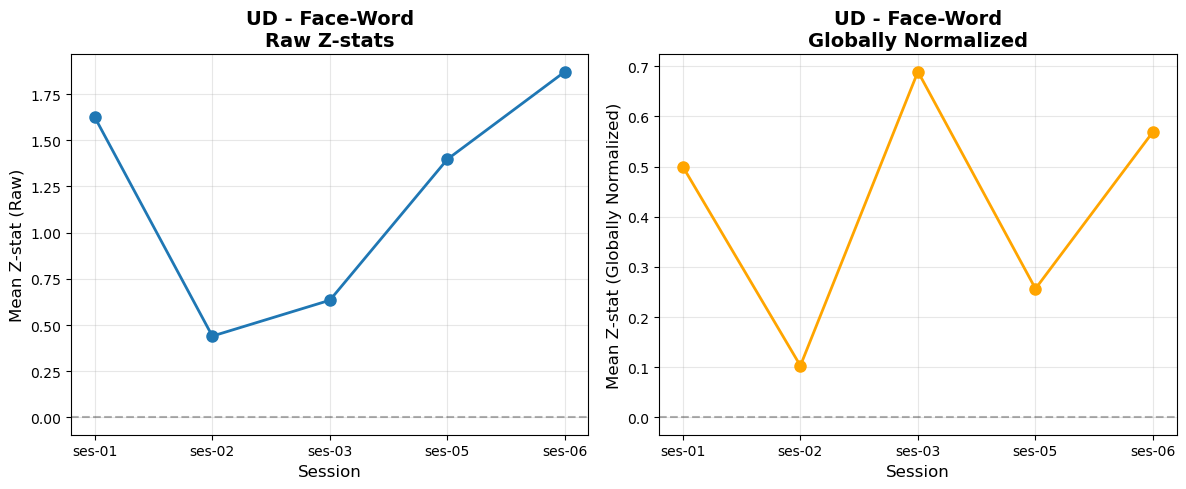


UD - Face-Word Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             1.62         0.50        -1.12
ses-02             0.44         0.10        -0.34
ses-03             0.63         0.69         0.05
ses-05             1.40         0.26        -1.14
ses-06             1.87         0.57        -1.30




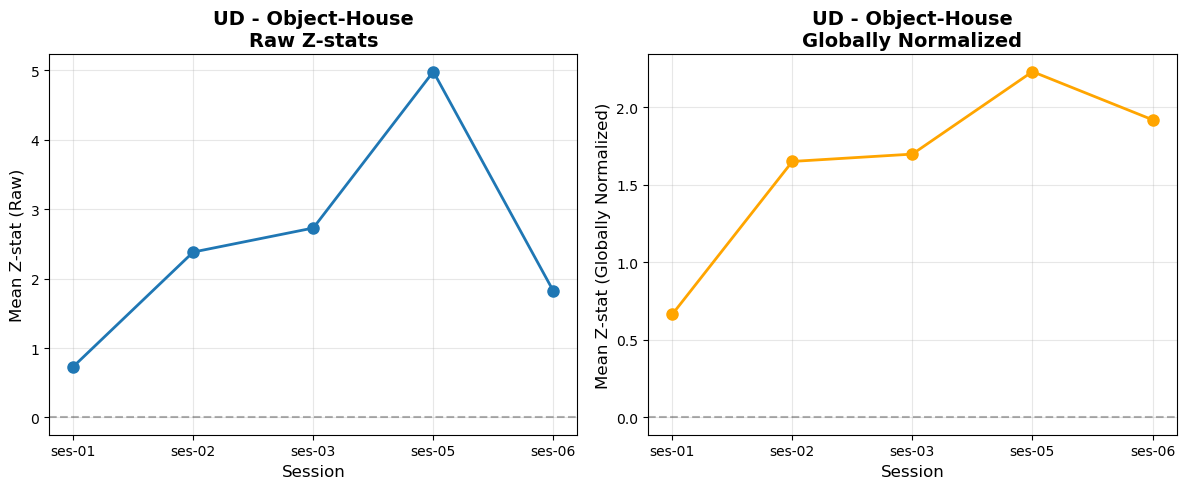


UD - Object-House Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             0.73         0.67        -0.07
ses-02             2.38         1.65        -0.73
ses-03             2.73         1.70        -1.03
ses-05             4.98         2.23        -2.75
ses-06             1.82         1.92         0.10




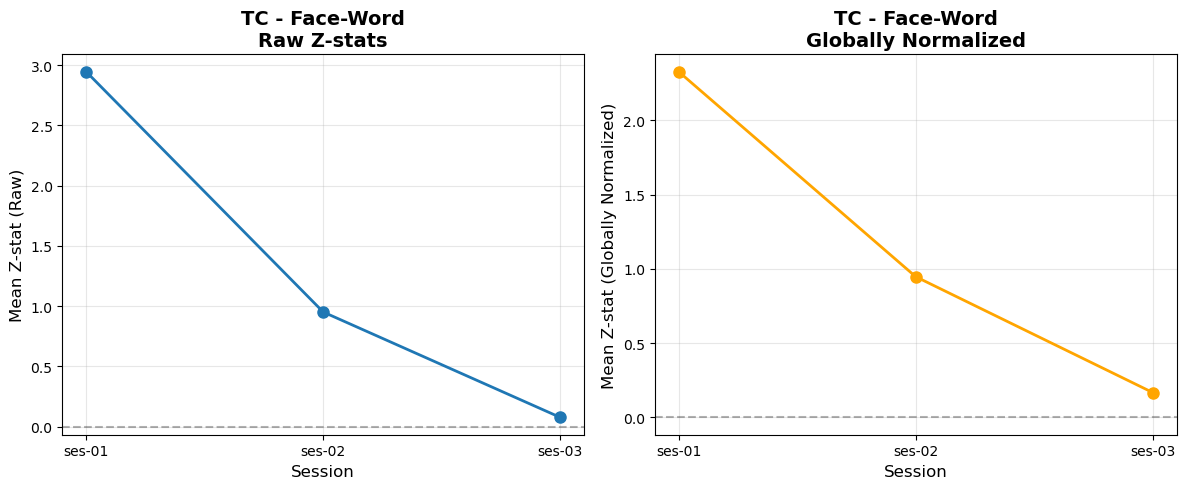


TC - Face-Word Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             2.95         2.33        -0.62
ses-02             0.95         0.95        -0.00
ses-03             0.08         0.17         0.09




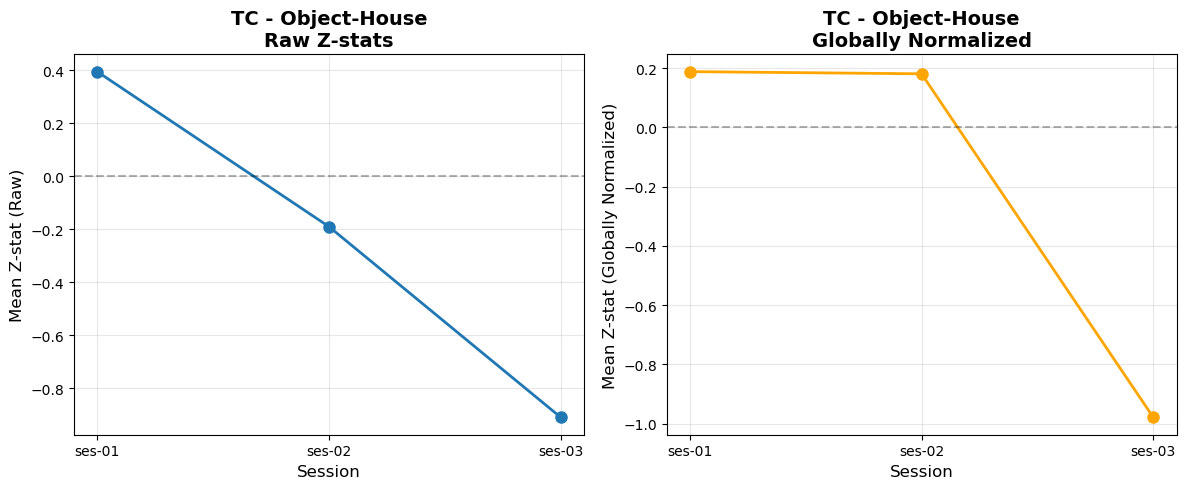


TC - Object-House Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             0.39         0.19        -0.21
ses-02            -0.19         0.18         0.37
ses-03            -0.91        -0.98        -0.07




In [26]:
# NEW CELL 3: Visualize the effect of global normalization
def plot_normalization_effect(subject_id, roi_type='face_word'):
    """
    Plot raw vs normalized values to show effect of global normalization
    """
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    
    # Extract both versions
    raw_data, n_vox, _, raw_stats = extract_contrast_values_v2(
        subject_id, roi_type, use_anatomical_only=False, global_normalize=False)
    norm_data, _, _, norm_stats = extract_contrast_values_v2(
        subject_id, roi_type, use_anatomical_only=False, global_normalize=True)
    
    sessions = sorted(raw_data.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Raw means
    raw_means = [raw_data[s].mean() for s in sessions]
    axes[0].plot(range(len(sessions)), raw_means, 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Session', fontsize=12)
    axes[0].set_ylabel('Mean Z-stat (Raw)', fontsize=12)
    axes[0].set_title(f'{code} - {roi_name}\nRaw Z-stats', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(sessions)))
    axes[0].set_xticklabels([f'ses-{s}' for s in sessions])
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Plot 2: Normalized means
    norm_means = [norm_data[s].mean() for s in sessions]
    axes[1].plot(range(len(sessions)), norm_means, 'o-', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Session', fontsize=12)
    axes[1].set_ylabel('Mean Z-stat (Globally Normalized)', fontsize=12)
    axes[1].set_title(f'{code} - {roi_name}\nGlobally Normalized', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(sessions)))
    axes[1].set_xticklabels([f'ses-{s}' for s in sessions])
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison
    print(f"\n{code} - {roi_name} Trajectory Comparison:")
    print("="*60)
    print(f"{'Session':<10} {'Raw Mean':>12} {'Norm Mean':>12} {'Difference':>12}")
    print("-"*60)
    for i, s in enumerate(sessions):
        diff = norm_means[i] - raw_means[i]
        print(f"ses-{s:<6} {raw_means[i]:>12.2f} {norm_means[i]:>12.2f} {diff:>12.2f}")

# Visualize all
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        plot_normalization_effect(subject_id, roi_type)
        print("\n")

In [27]:
# Check data quality metrics per session
def check_session_quality(subject_id):
    """Check tSNR and global signal across sessions"""
    
    print(f"\n{subject_id} Data Quality Check")
    print("="*60)
    
    for session in SUBJECTS[subject_id]['sessions']:
        if session == '01':
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / 'cope13.feat' / 'stats' / 'zstat1.nii.gz'
        else:
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / 'cope13.feat' / 'stats' / 'zstat1_ses01.nii.gz'
        
        if zstat_file.exists():
            data = nib.load(zstat_file).get_fdata()
            brain_mask = data != 0
            
            brain_mean = data[brain_mask].mean()
            brain_std = data[brain_mask].std()
            brain_median = np.median(data[brain_mask])
            
            print(f"ses-{session}:")
            print(f"  Global mean: {brain_mean:.3f}")
            print(f"  Global std:  {brain_std:.3f}")
            print(f"  Global median: {brain_median:.3f}")

for subject_id in ['sub-004', 'sub-021']:
    check_session_quality(subject_id)


sub-004 Data Quality Check
ses-01:
  Global mean: 1.006
  Global std:  1.237
  Global median: 1.076
ses-02:
  Global mean: 0.314
  Global std:  1.226
  Global median: 0.259
ses-03:
  Global mean: -0.082
  Global std:  1.040
  Global median: -0.091
ses-05:
  Global mean: 1.059
  Global std:  1.320
  Global median: 1.059
ses-06:
  Global mean: 1.166
  Global std:  1.238
  Global median: 1.095

sub-021 Data Quality Check
ses-01:
  Global mean: 0.173
  Global std:  1.191
  Global median: 0.134
ses-02:
  Global mean: 0.030
  Global std:  0.973
  Global median: 0.014
ses-03:
  Global mean: -0.124
  Global std:  1.197
  Global median: -0.070


In [ ]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'  # FIXED: was cond2_name
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name


UD - Tracking in Native Clusters:
FACE in face cluster:
  ses-01: 1.61
  ses-02: 1.62
  ses-03: 1.59
  ses-05: 2.19
  ses-06: 3.04

WORD in word cluster:
  ses-01: 0.93
  ses-02: 1.04
  ses-03: -0.05
  ses-05: -0.16
  ses-06: 0.12

TC - Tracking in Native Clusters:
FACE in face cluster:
  ses-01: 9.54
  ses-02: 3.87
  ses-03: 7.07

WORD in word cluster:
  ses-01: 0.00
  ses-02: 1.66
  ses-03: 2.08


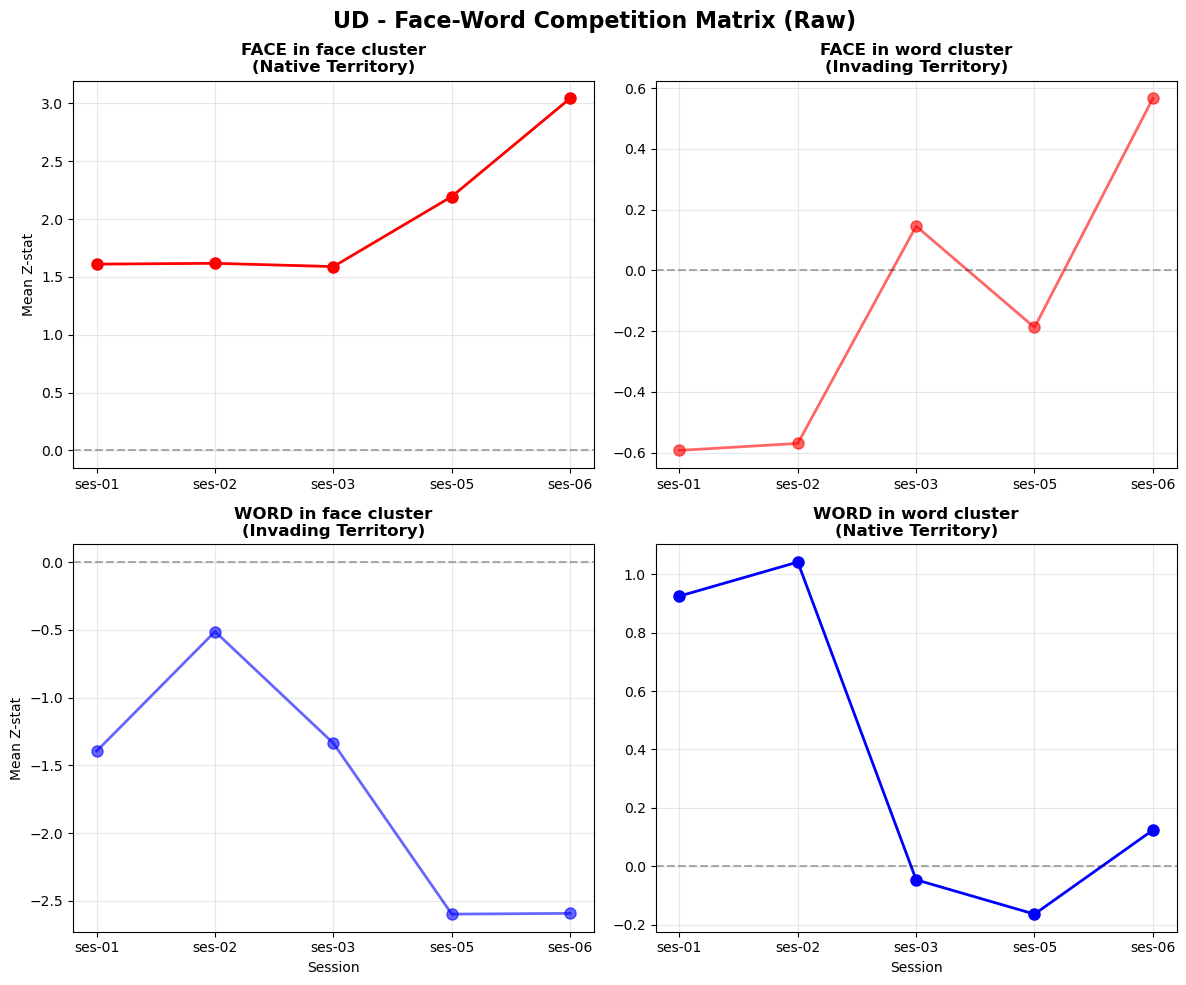


UD - Face-Word Competition Matrix (Raw)

ses-01:
  FACE in face cluster: 1.61
  FACE in word cluster: -0.59
  WORD in face cluster: -1.39
  WORD in word cluster: 0.93

ses-02:
  FACE in face cluster: 1.62
  FACE in word cluster: -0.57
  WORD in face cluster: -0.51
  WORD in word cluster: 1.04

ses-03:
  FACE in face cluster: 1.59
  FACE in word cluster: 0.15
  WORD in face cluster: -1.34
  WORD in word cluster: -0.05

ses-05:
  FACE in face cluster: 2.19
  FACE in word cluster: -0.19
  WORD in face cluster: -2.60
  WORD in word cluster: -0.16

ses-06:
  FACE in face cluster: 3.04
  FACE in word cluster: 0.57
  WORD in face cluster: -2.59
  WORD in word cluster: 0.12


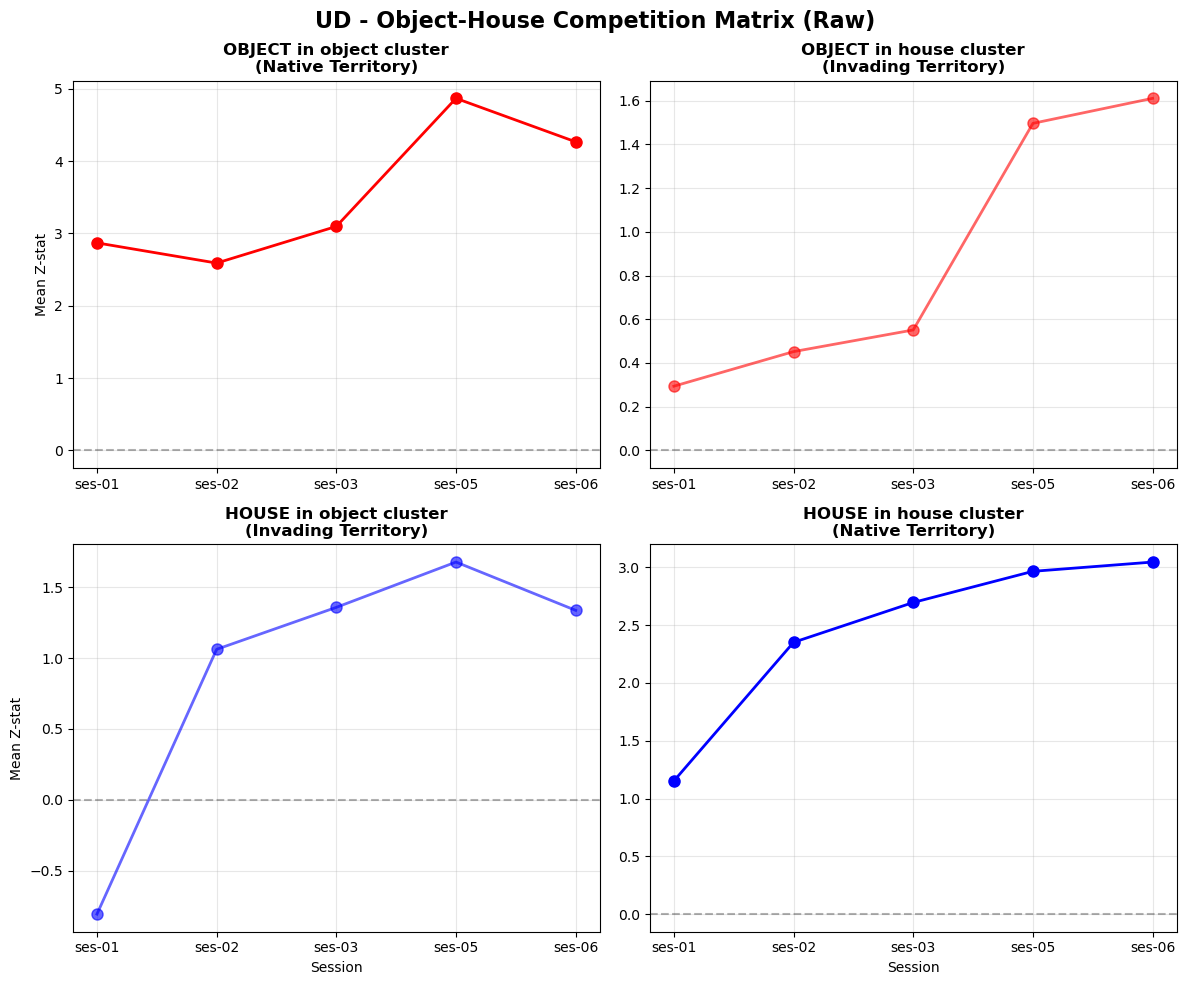


UD - Object-House Competition Matrix (Raw)

ses-01:
  OBJECT in object cluster: 2.87
  OBJECT in house cluster: 0.29
  HOUSE in object cluster: -0.81
  HOUSE in house cluster: 1.15

ses-02:
  OBJECT in object cluster: 2.59
  OBJECT in house cluster: 0.45
  HOUSE in object cluster: 1.06
  HOUSE in house cluster: 2.35

ses-03:
  OBJECT in object cluster: 3.10
  OBJECT in house cluster: 0.55
  HOUSE in object cluster: 1.36
  HOUSE in house cluster: 2.70

ses-05:
  OBJECT in object cluster: 4.87
  OBJECT in house cluster: 1.50
  HOUSE in object cluster: 1.68
  HOUSE in house cluster: 2.97

ses-06:
  OBJECT in object cluster: 4.26
  OBJECT in house cluster: 1.61
  HOUSE in object cluster: 1.34
  HOUSE in house cluster: 3.05


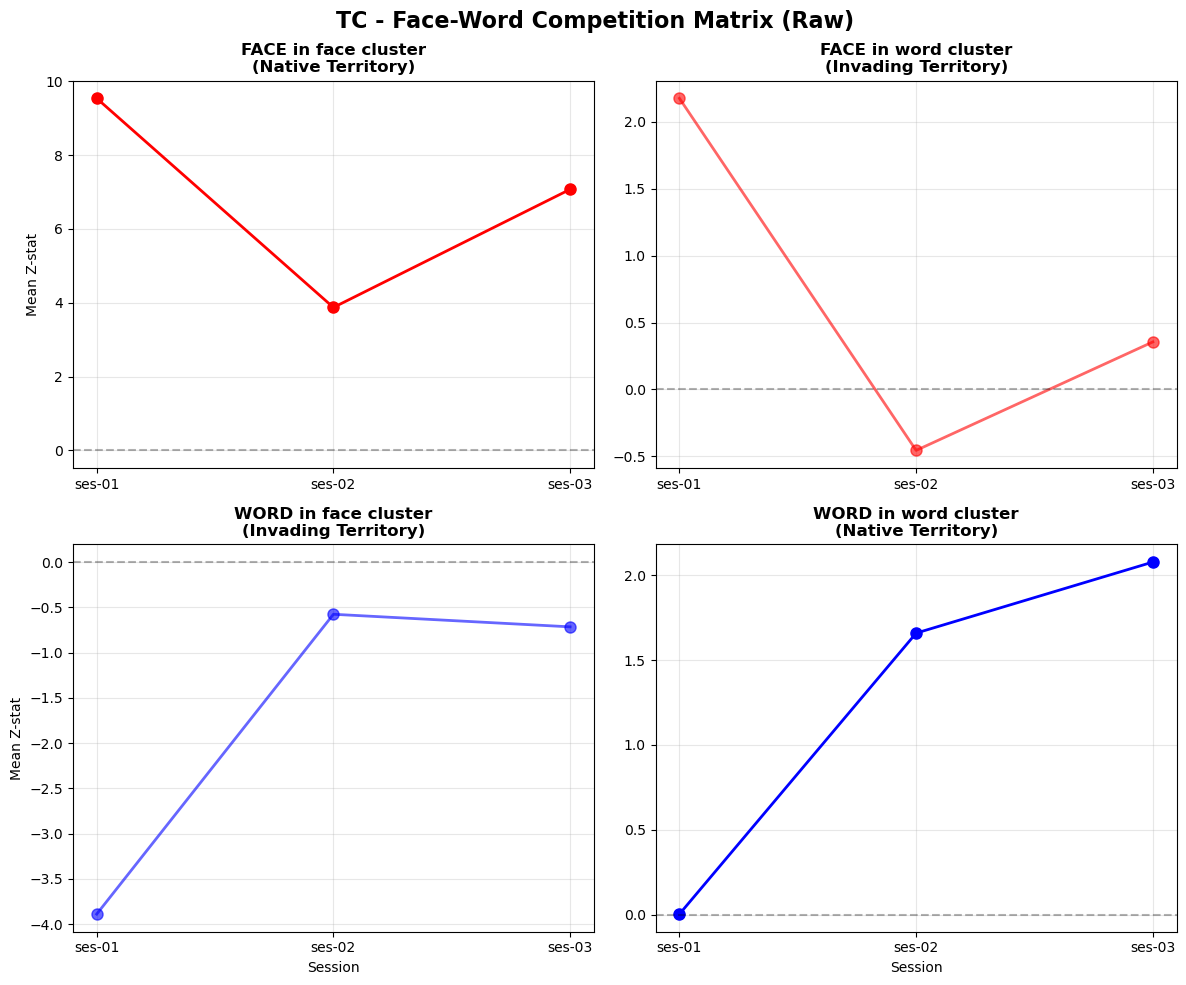


TC - Face-Word Competition Matrix (Raw)

ses-01:
  FACE in face cluster: 9.54
  FACE in word cluster: 2.18
  WORD in face cluster: -3.89
  WORD in word cluster: 0.00

ses-02:
  FACE in face cluster: 3.87
  FACE in word cluster: -0.46
  WORD in face cluster: -0.58
  WORD in word cluster: 1.66

ses-03:
  FACE in face cluster: 7.07
  FACE in word cluster: 0.36
  WORD in face cluster: -0.72
  WORD in word cluster: 2.08


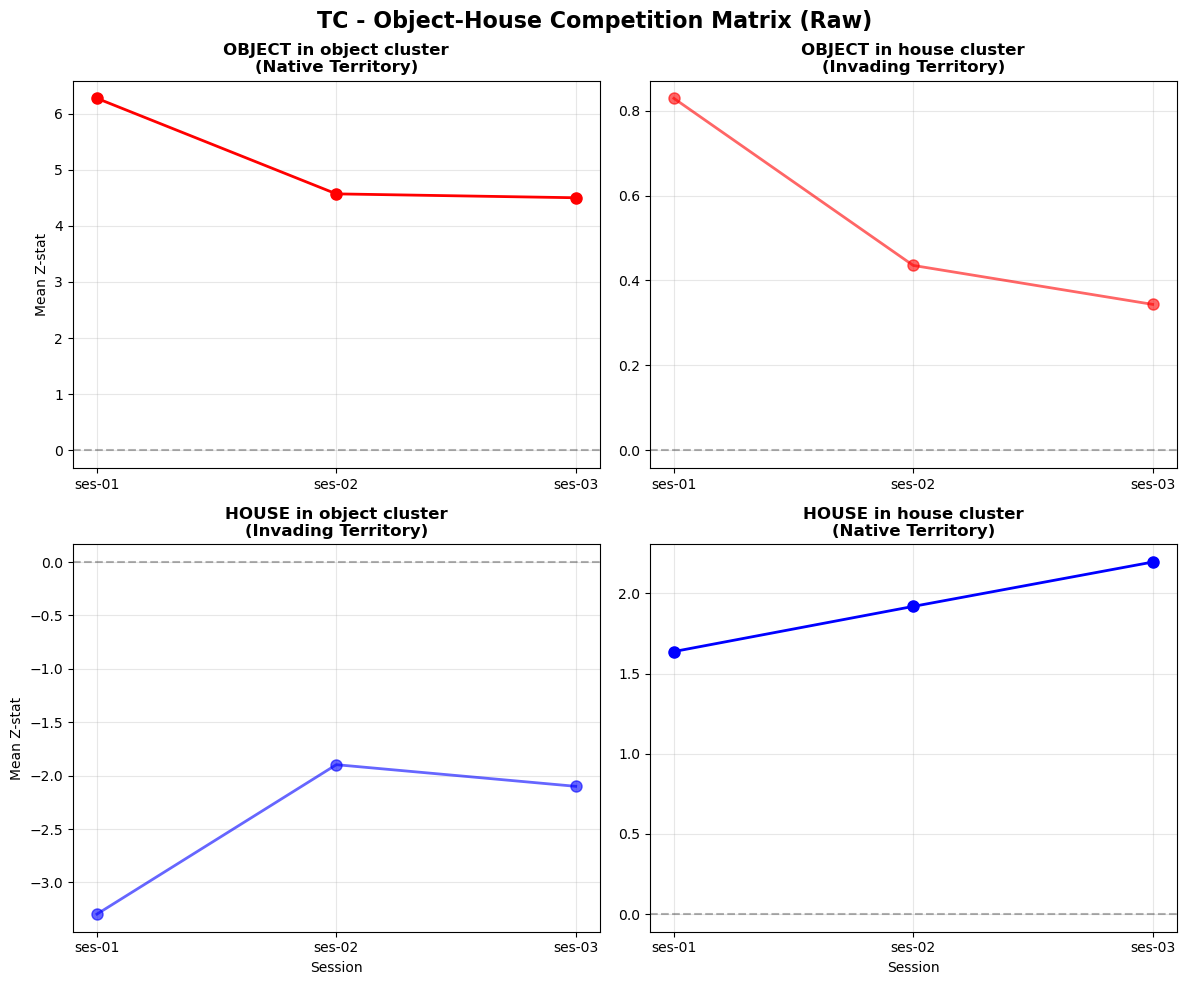


TC - Object-House Competition Matrix (Raw)

ses-01:
  OBJECT in object cluster: 6.27
  OBJECT in house cluster: 0.83
  HOUSE in object cluster: -3.30
  HOUSE in house cluster: 1.64

ses-02:
  OBJECT in object cluster: 4.57
  OBJECT in house cluster: 0.44
  HOUSE in object cluster: -1.90
  HOUSE in house cluster: 1.92

ses-03:
  OBJECT in object cluster: 4.50
  OBJECT in house cluster: 0.34
  HOUSE in object cluster: -2.10
  HOUSE in house cluster: 2.20


In [33]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name

def plot_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Plot 2x2 grid showing all condition×cluster combinations
    """
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    norm_label = "Normalized" if global_normalize else "Raw"
    
    results, cond1_name, cond2_name = extract_competition_matrix(
        subject_id, roi_type, global_normalize)
    
    sessions = SUBJECTS[subject_id]['sessions']
    session_nums = list(range(len(sessions)))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{code} - {roi_name} Competition Matrix ({norm_label})', 
                 fontsize=16, fontweight='bold')
    
    # Top left: Condition 1 in Cluster 1 (native territory)
    means = [results[cond1_name]['cluster1'][s] for s in sessions]
    axes[0, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red')
    axes[0, 0].set_title(f'{cond1_name.upper()} in {cond1_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[0, 0].set_ylabel('Mean Z-stat')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 0].set_xticks(session_nums)
    axes[0, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Top right: Condition 1 in Cluster 2 (invading)
    means = [results[cond1_name]['cluster2'][s] for s in sessions]
    axes[0, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red', alpha=0.6)
    axes[0, 1].set_title(f'{cond1_name.upper()} in {cond2_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].set_xticks(session_nums)
    axes[0, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom left: Condition 2 in Cluster 1 (invading)
    means = [results[cond2_name]['cluster1'][s] for s in sessions]
    axes[1, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue', alpha=0.6)
    axes[1, 0].set_title(f'{cond2_name.upper()} in {cond1_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[1, 0].set_xlabel('Session')
    axes[1, 0].set_ylabel('Mean Z-stat')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 0].set_xticks(session_nums)
    axes[1, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom right: Condition 2 in Cluster 2 (native territory)
    means = [results[cond2_name]['cluster2'][s] for s in sessions]
    axes[1, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue')
    axes[1, 1].set_title(f'{cond2_name.upper()} in {cond2_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[1, 1].set_xlabel('Session')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xticks(session_nums)
    axes[1, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    plt.tight_layout()
    plt.show()
    
    # Print full matrix
    print(f"\n{code} - {roi_name} Competition Matrix ({norm_label})")
    print("="*80)
    for session in sessions:
        print(f"\nses-{session}:")
        print(f"  {cond1_name.upper()} in {cond1_name} cluster: {results[cond1_name]['cluster1'][session]:.2f}")
        print(f"  {cond1_name.upper()} in {cond2_name} cluster: {results[cond1_name]['cluster2'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond1_name} cluster: {results[cond2_name]['cluster1'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond2_name} cluster: {results[cond2_name]['cluster2'][session]:.2f}")

# Run for both subjects and ROI types
for subject_id in ['sub-004', 'sub-021']:
    plot_competition_matrix(subject_id, 'face_word', global_normalize=False)
    plot_competition_matrix(subject_id, 'object_house', global_normalize=False)